<a href="https://colab.research.google.com/github/Doclikam/Causal-inference-for-Treatment-Effects-in-Head-Neck-Radiotherapy./blob/main/Casual_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RADCURE - CHEMOTHERAPY/RADIOTHERAPY CANCER RESPONSE**

In [ ]:
#main libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

import joblib
import os
os.makedirs("outputs", exist_ok=True)

# Display all columns
pd.set_option('display.max_columns', None)


In [110]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [ ]:
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [ ]:
rad_analysis = pd.read_csv("/content/rad_data_analysis.csv")#load the excel file
rad_analysis.head(5)#visulize the first 5 patients

,patient_id,treatment,time_os_days,event_os,time_pfs_days,event_pfs,time_pfs_days.1,event_pfs.1,age,sex,ecog_ps,ecog_ps_missing,smoking_status_clean,smoking_py_clean,smoking_py_missing,smoking_mismatch_flag,primary_site_group,subsite_clean,subsite_missing,t,n,m,stage,t_missing,n_missing,m_missing,stage_missing,hpv_clean,hpv_missing,hpv_specific_tumors,pathology_group,is_non_tnm,tnm_structural_missing,followup_days
0,RADCURE-0005,0,446.0,1,446.0,1,446.0,1,62.6,Female,0.0,0,Ex-Smoker,50.0,0,0,Oropharynx,Post Wall,0,T4b,N2c,M0,IVB,0,0,0,0,HPV_Negative,0,1,SCC,0,0,446.0
1,RADCURE-0006,0,527.0,1,527.0,1,527.0,1,87.3,Male,2.0,0,Ex-Smoker,25.0,0,0,Larynx,Glottis,0,T1b,N0,M0,I,0,0,0,0,NaN,0,0,SCC,0,0,527.0
2,RADCURE-0007,0,756.0,0,756.0,0,756.0,0,49.9,Male,1.0,0,Ex-Smoker,15.0,0,0,Oropharynx,Tonsil,0,T3,N2b,M0,IVA,0,0,0,0,HPV_Positive,0,1,SCC,0,0,756.0
3,RADCURE-0009,0,2059.0,0,2059.0,0,2059.0,0,72.3,Male,1.0,0,Ex-Smoker,30.0,0,0,Other_HNC,NaN,0,T0,N2c,M0,IVA,0,0,0,0,NaN,0,0,SCC,0,0,2059.0
4,RADCURE-0010,0,3444.0,0,3444.0,0,3444.0,0,59.7,Female,0.0,0,Non-Smoker,0.0,0,0,Oropharynx,Tonsillar Fossa,0,T4b,N0,M0,IVB,0,0,0,0,HPV_Negative,0,1,SCC,0,0,3444.0


In [ ]:
rad_analysis.columns

Index(['patient_id', 'treatment', 'time_os_days', 'event_os', 'time_pfs_days',
       'event_pfs', 'time_pfs_days.1', 'event_pfs.1', 'age', 'sex', 'ecog_ps',
       'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean',
       'smoking_py_missing', 'smoking_mismatch_flag', 'primary_site_group',
       'subsite_clean', 'subsite_missing', 't', 'n', 'm', 'stage', 't_missing',
       'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing',
       'hpv_specific_tumors', 'pathology_group', 'is_non_tnm',
       'tnm_structural_missing', 'followup_days'],
      dtype='object')

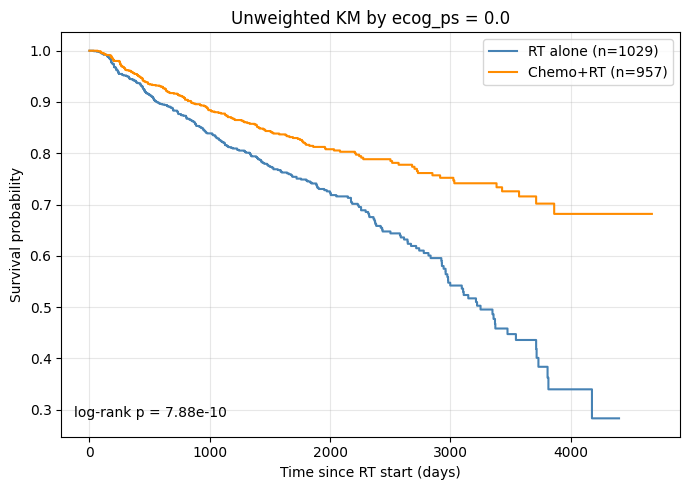

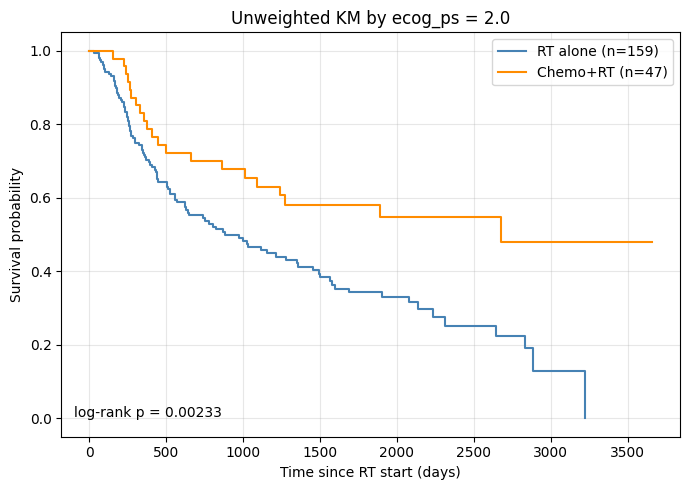

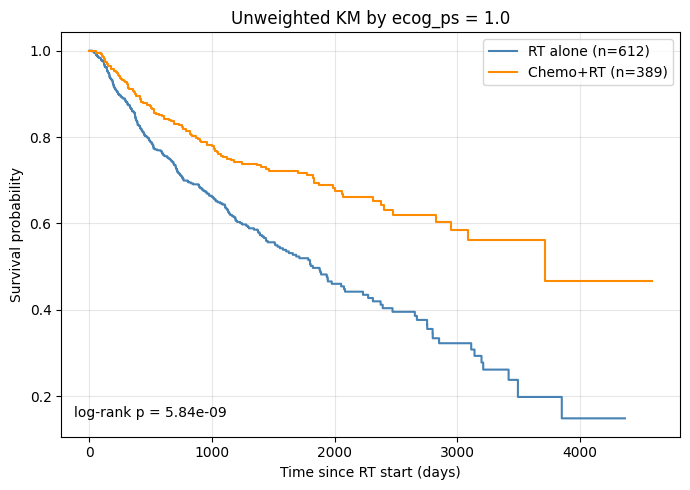

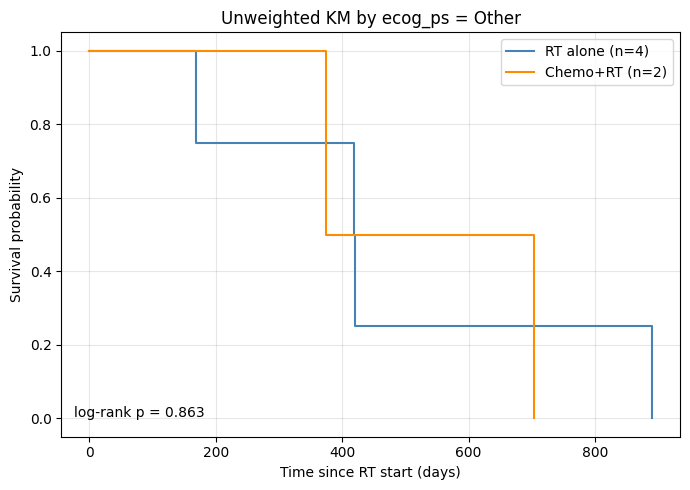

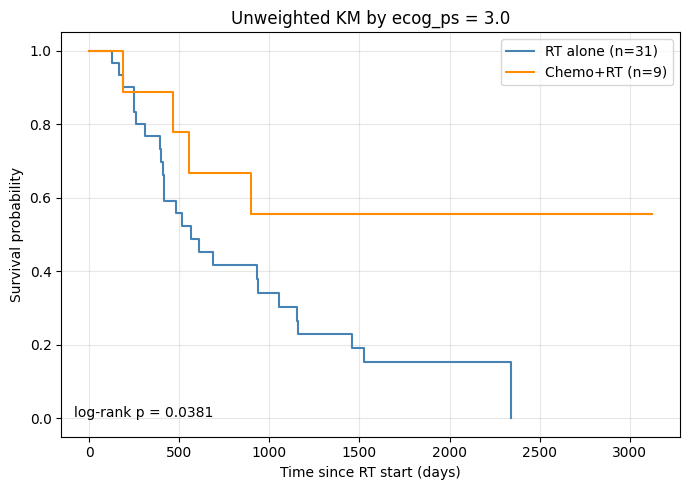

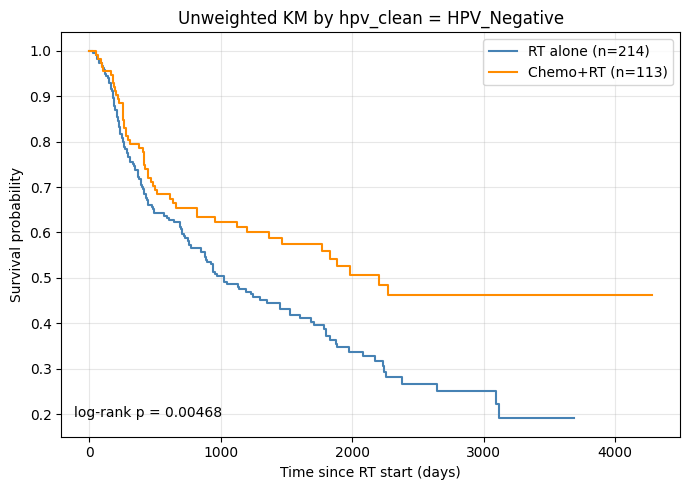

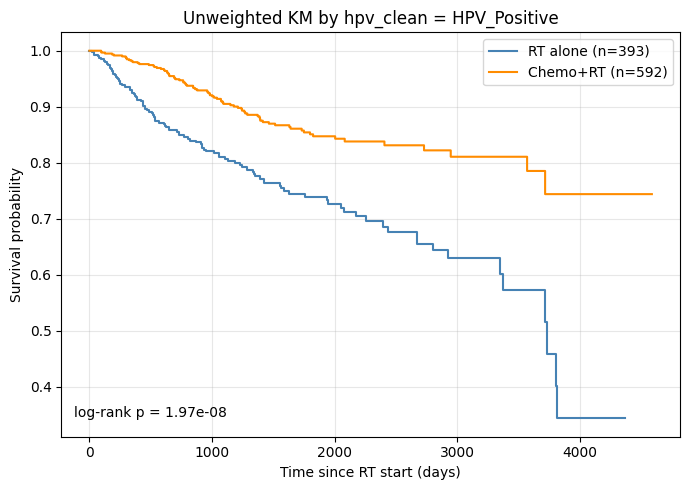

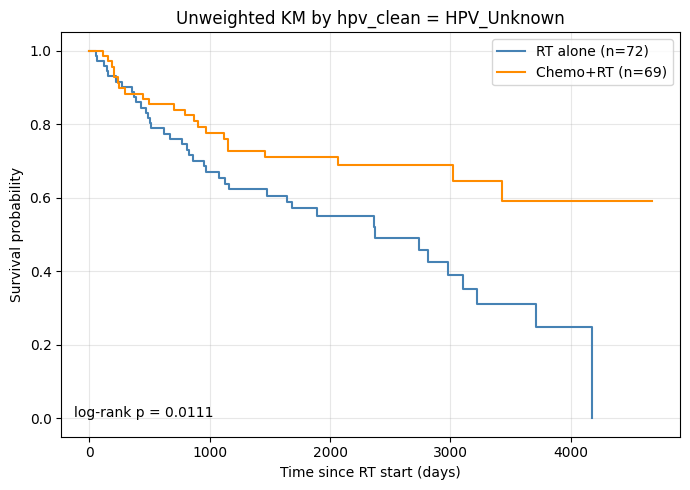

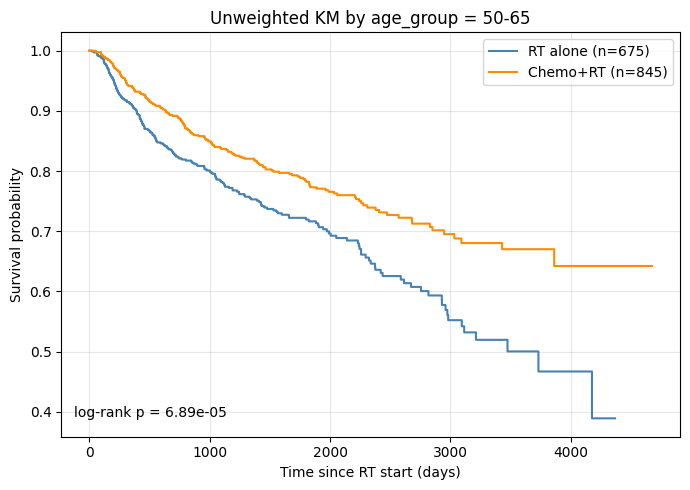

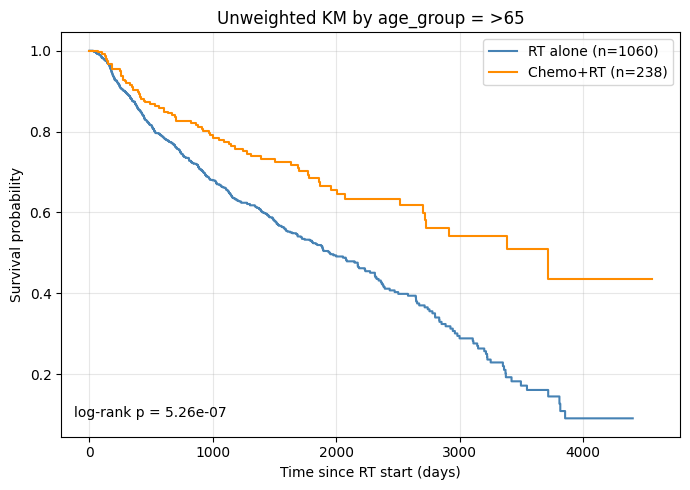

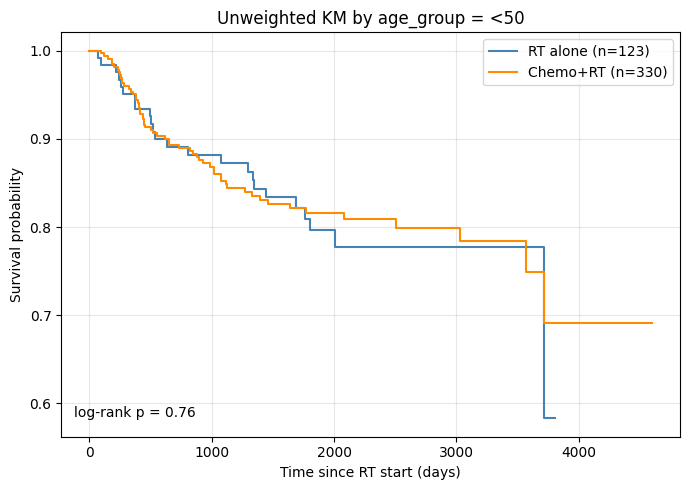

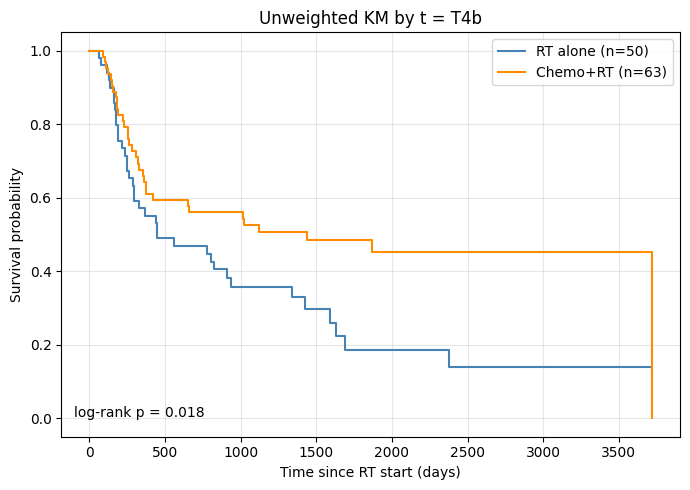

Skipping t=T1b (no patients in one arm).


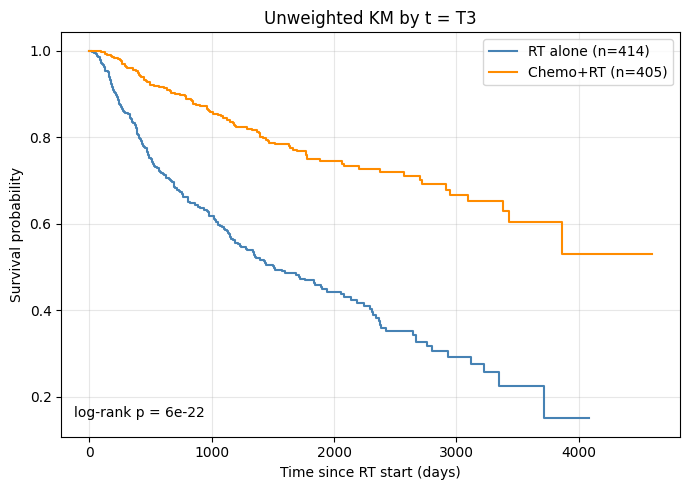

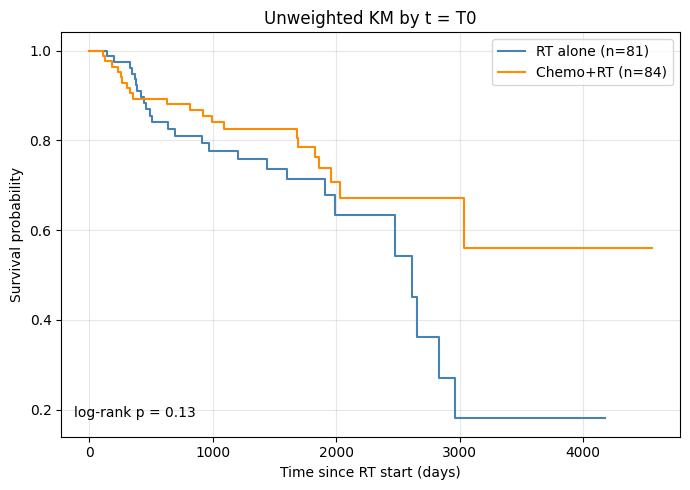

Skipping t=T1a (no patients in one arm).


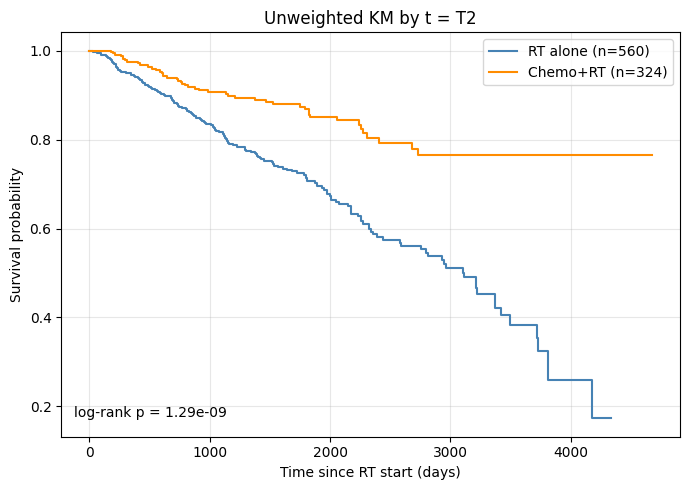

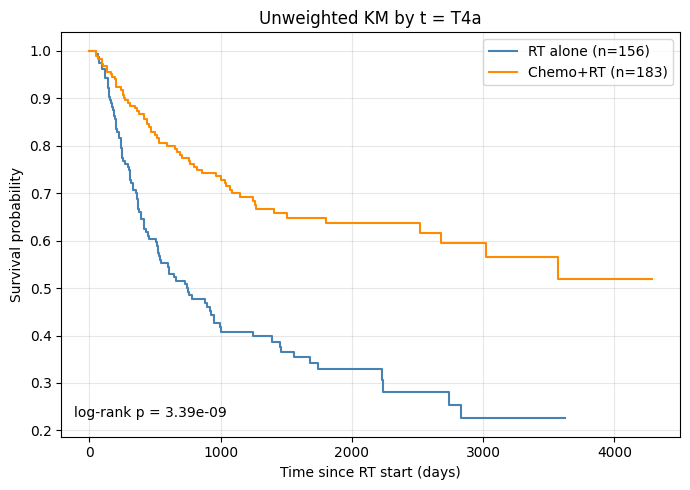

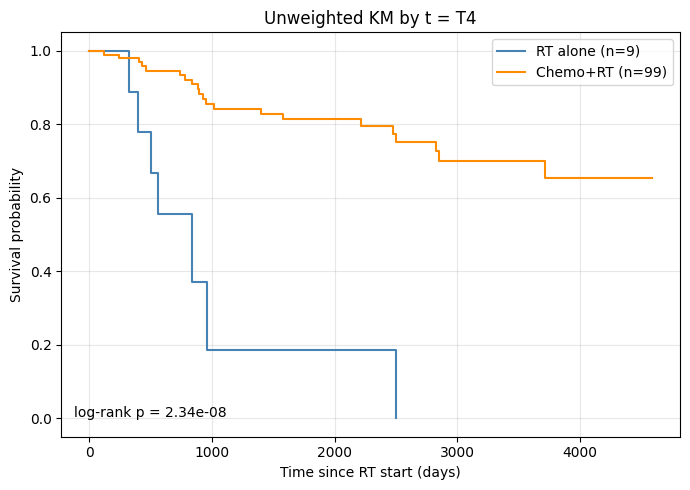

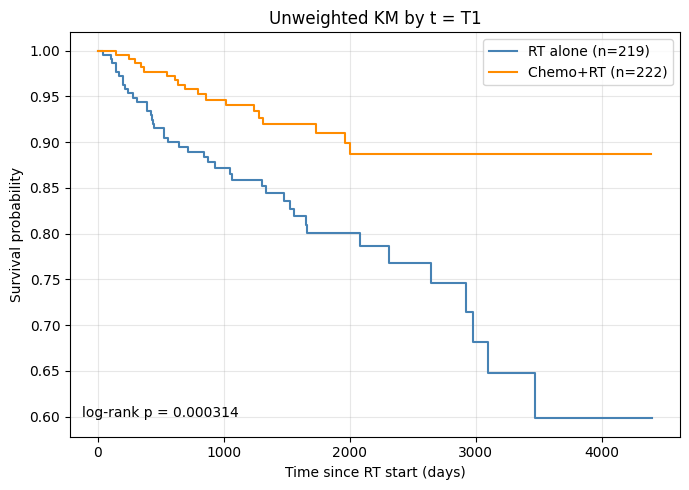

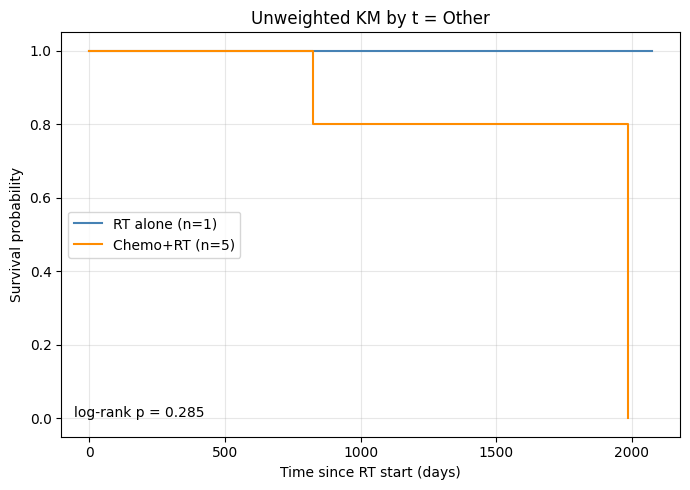

Skipping t=Tis (no patients in one arm).


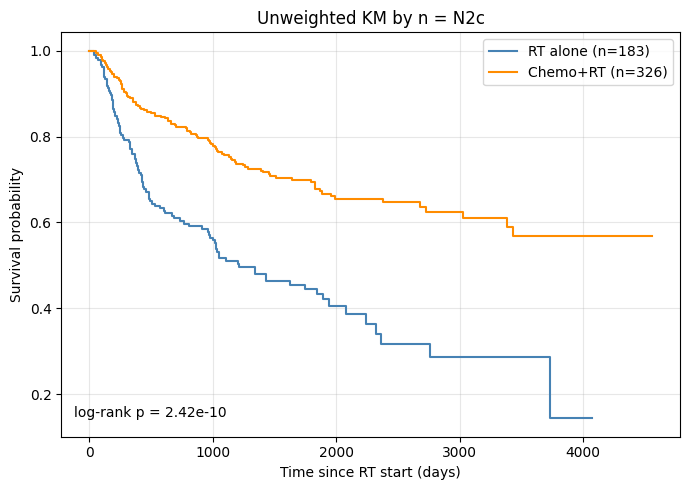

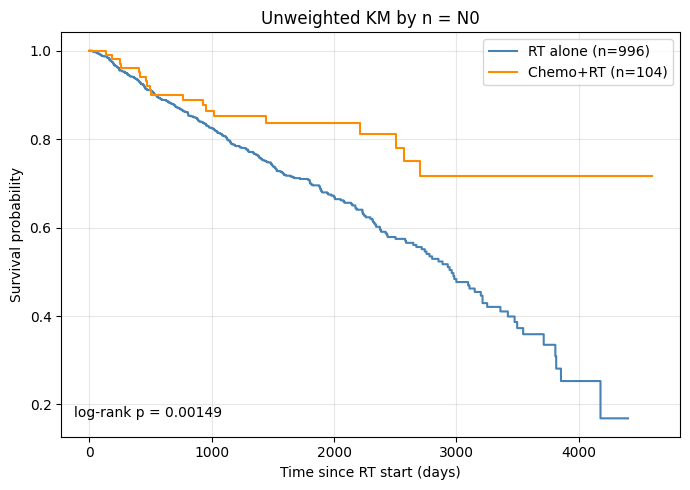

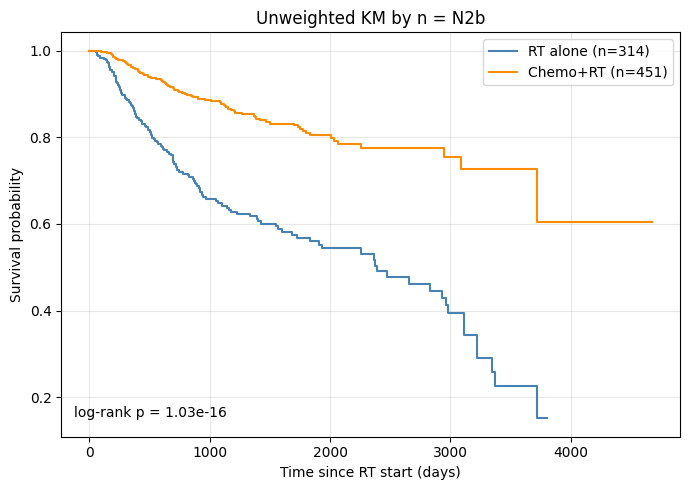

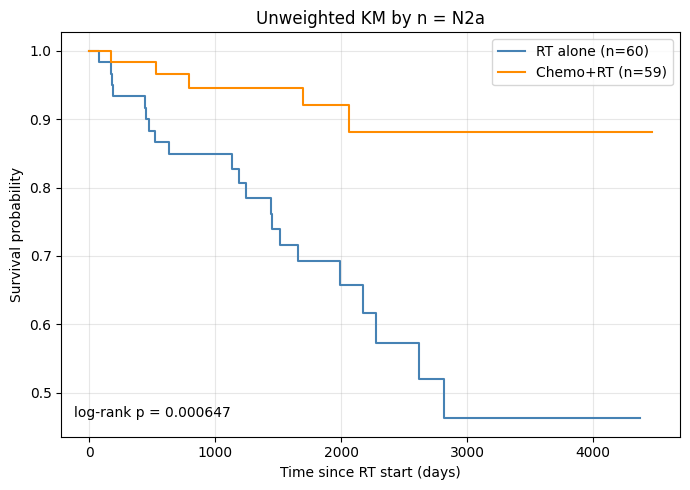

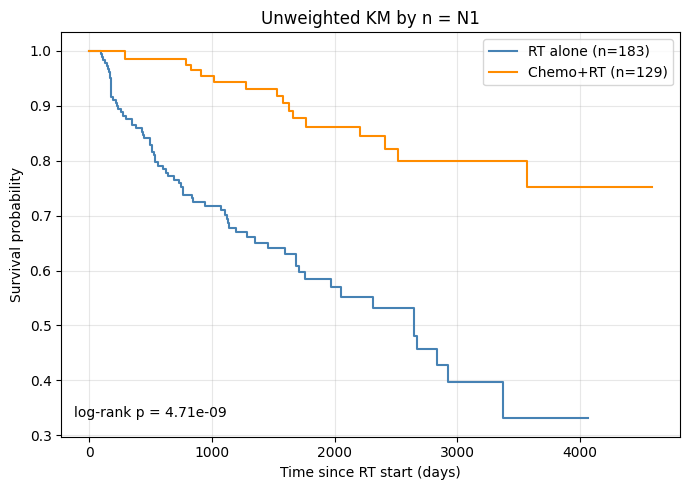

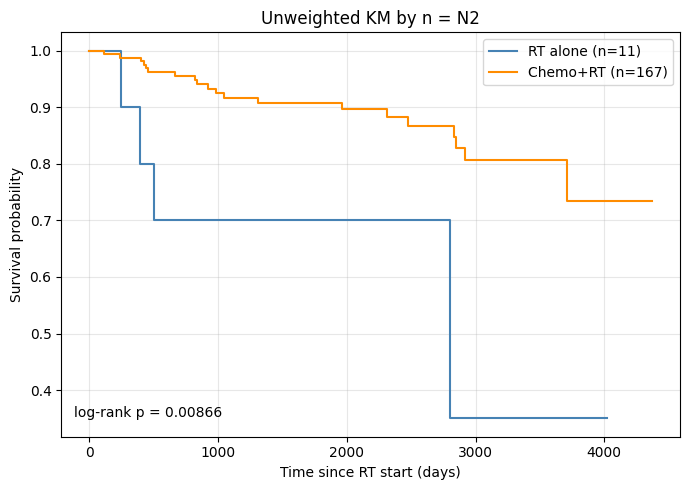

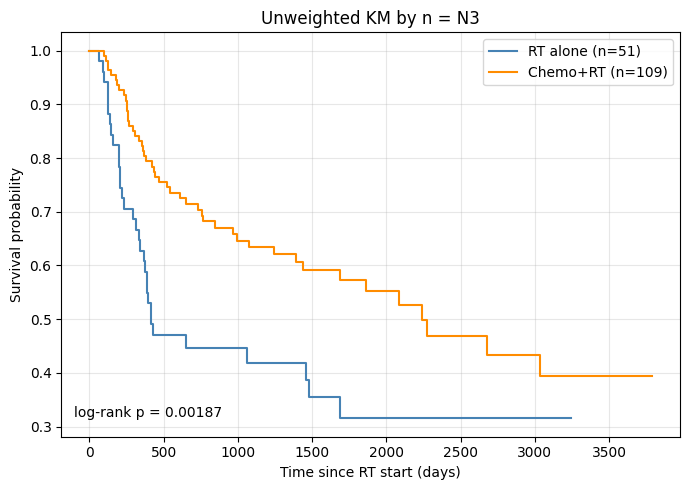

Skipping n=N3b (no patients in one arm).


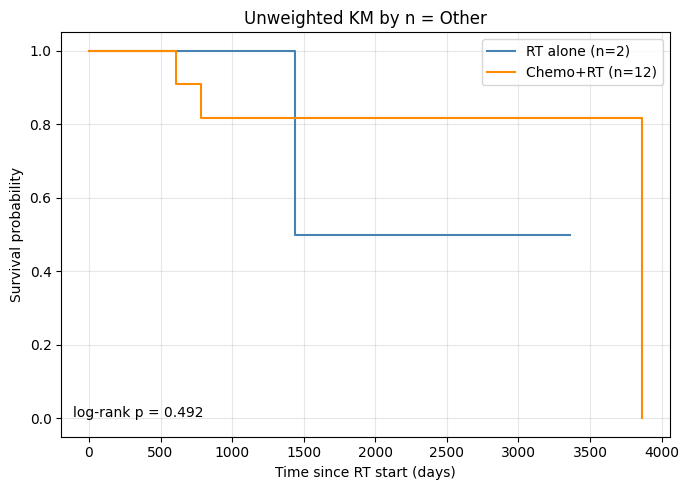

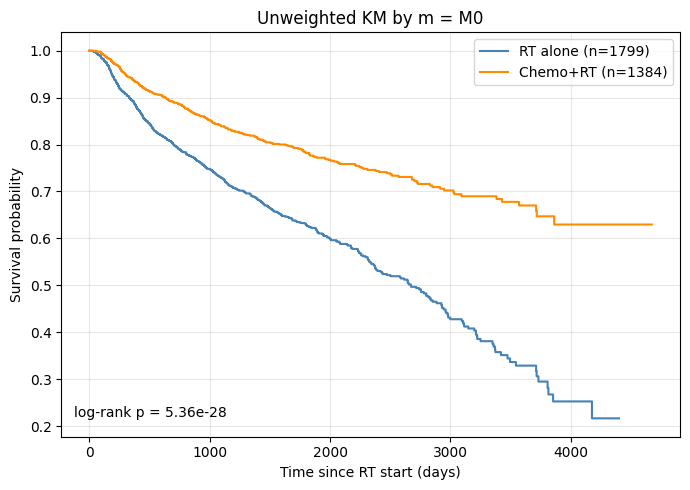

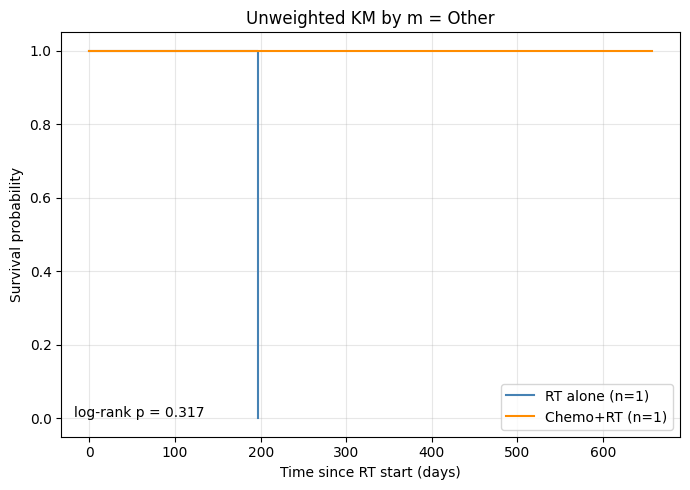

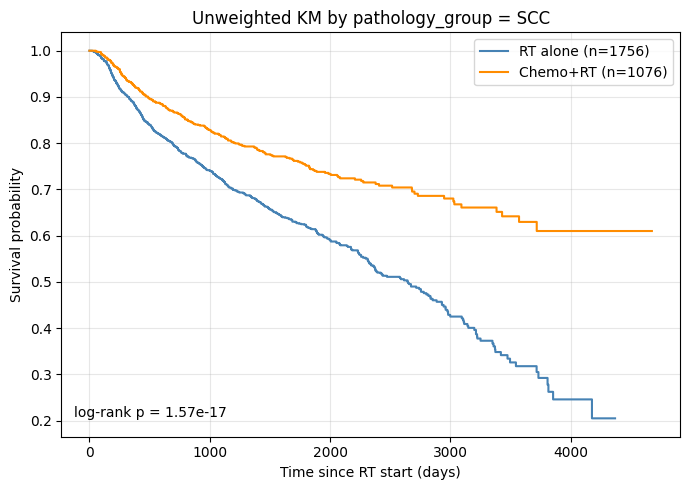

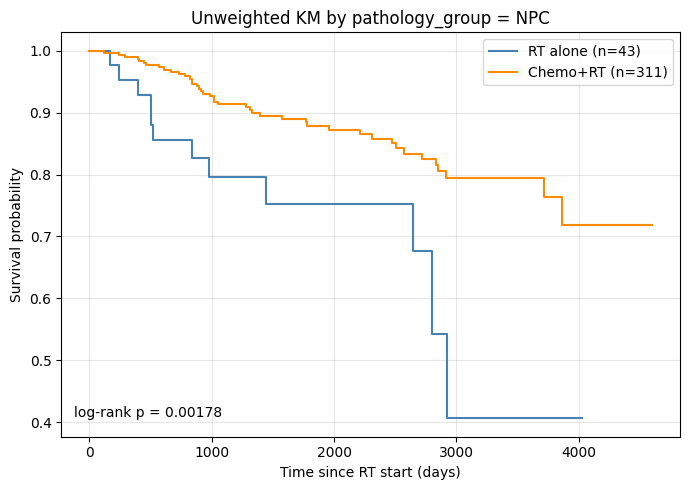

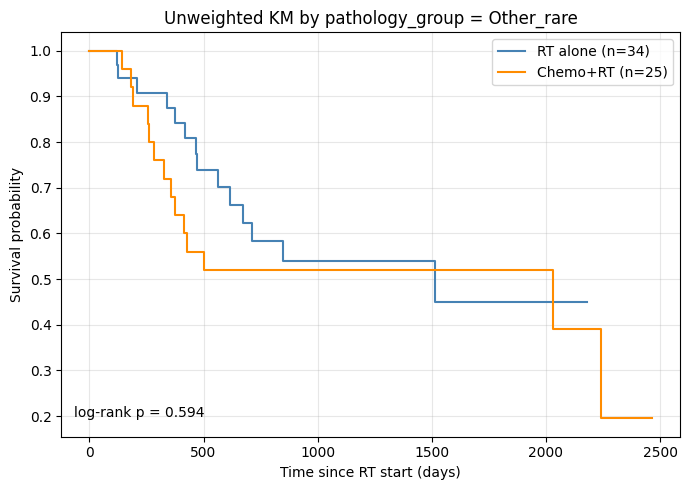

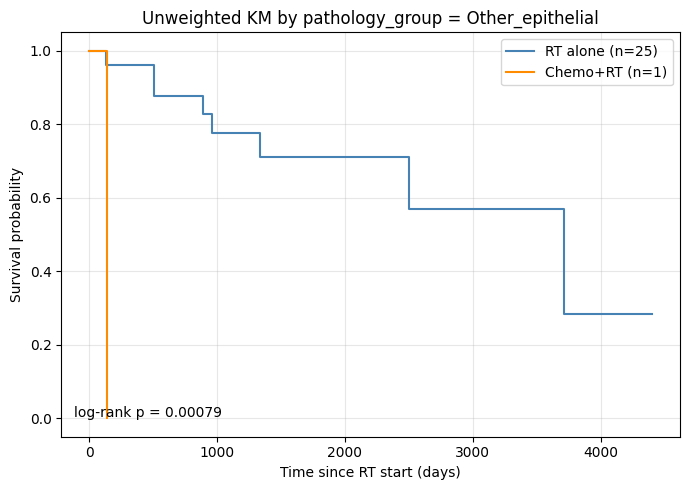

In [ ]:
# Working copy (unweighted)
df_unw = rad_analysis.copy()

# Create simple age groups (adjust bins if you prefer)
if 'age' in df_unw.columns:
    bins = [0, 50, 65, 120]                # <50, 50-65, >65
    labels = ['<50', '50-65', '>65']
    df_unw['age_group'] = pd.cut(df_unw['age'], bins=bins, labels=labels, right=False)

# Basic KM plotting function for unweighted data
def plot_unweighted_km_by_group(df, group_col, title_prefix="Unweighted KM by"):
    """Plot unweighted Kaplan–Meier curves stratified by treatment within each level of group_col."""
    if group_col not in df.columns:
        print(f"Column {group_col} not found — skipping.")
        return

    levels = df[group_col].dropna().unique()
    levels = sorted(levels, key=lambda x: (str(x)))  # stable order

    for lvl in levels:
        subset = df[df[group_col] == lvl]
        if subset.empty:
            continue

        # require at least 5 patients per treatment to plot
        counts = subset['treatment'].value_counts()
        if counts.min() if counts.size>1 else 0 < 5:
            print(f"Skipping {group_col}={lvl} (too few patients in one treatment arm).")
            continue

        T = subset['time_os_days']
        E = subset['event_os']
        A = subset['treatment']

        km0 = KaplanMeierFitter(label=f"RT alone — {group_col}={lvl}")
        km1 = KaplanMeierFitter(label=f"Chemo+RT — {group_col}={lvl}")

        plt.figure(figsize=(7,5))
        km0.fit(T[A==0], event_observed=E[A==0])
        km1.fit(T[A==1], event_observed=E[A==1])

        ax = km0.plot(ci_show=True, color='steelblue')
        km1.plot(ci_show=True, color='darkorange', ax=ax)

        plt.title(f"{title_prefix} {group_col} = {lvl}")
        plt.xlabel("Time since RT start (days)")
        plt.ylabel("Survival probability")
        plt.grid(alpha=0.3)
        plt.tight_layout()

        # Optional: unweighted log-rank test between treatment groups in this subgroup
        try:
            lr = logrank_test(T[A==0], T[A==1], event_observed_A=E[A==0], event_observed_B=E[A==1])
            pval = lr.p_value
            plt.annotate(f"log-rank p = {pval:.3g}", xy=(0.02, 0.03), xycoords='axes fraction')
        except Exception:
            pass

        plt.show()


# Columns to plot (unweighted)
subgroup_columns = [
    'ecog_ps', 'hpv_clean', 'age_group',
    't', 'n', 'm', 'pathology_group'
]

for col in subgroup_columns:
    if col in df_unw.columns:
        plot_unweighted_km_by_group(df_unw, col, title_prefix="Unweighted KM by")

# Propensity Scores

propensity score (PS) model:
PS(x)=P(Treatment=1∣X=x)  


for each patient, what’s the probability they receive ChemoRT given their observed baseline characteristics X

Here:

X is a matrix of confounders (age, sex, ECOG, smoking, TNM, HPV, etc.) that influence treatment assignment.

y is a binary vector: 1 if patient received ChemoRT, 0 if RT alone.

In [ ]:
ps_covariates = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group',
    't', 'n', 'm',
    't_missing', 'n_missing', 'm_missing', 'stage_missing',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors'
]

#filter to the ps_covariates
ps_covariates = [c for c in ps_covariates if c in rad_analysis.columns]
print(f'The covariates: {ps_covariates}')

The covariates: ['age', 'sex', 'ecog_ps', 'ecog_ps_missing', 'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing', 'primary_site_group', 't', 'n', 'm', 't_missing', 'n_missing', 'm_missing', 'stage_missing', 'hpv_clean', 'hpv_missing', 'hpv_specific_tumors']


In [ ]:
#2. Preprocess covariates for PS model (one-hot categorical, median fill

#categorical columns2. Preprocess covariates for PS model (one-hot categorical, median fill for numerics)2. Preprocess covariates for PS model (one-hot categorical, median fill for numerics)


cat_cols = ['sex','smoking_status_clean','primary_site_group','t','n','m','hpv_clean']
cat_cols = [c for c in cat_cols if c in rad_analysis.columns]

#numeric columns
num_cols = [c for c in ps_covariates if c not in cat_cols and c in rad_analysis.columns]
#fill the numerical columns missing with median
rad_analysis[num_cols] = rad_analysis[num_cols].copy().fillna(rad_analysis[num_cols].median())


#onehot encode categorical columns
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, cat_cols)],
    remainder='passthrough'
)

X = preprocessor.fit_transform(rad_analysis[cat_cols + num_cols])
# feature names
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(ohe_cols) + num_cols

#treatment
y = rad_analysis['treatment'].astype(int).values


**P(Treatment=1∣X)=logistic(β0​+βX)**

In [ ]:
#propensity scores
#Fit logistic regression (L2 small penalty for stability)
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X, y)
ps = logreg.predict_proba(X)[:,1]
rad_analysis['ps'] = ps

# Save average predicted PS by treatment
print("Mean PS by treatment group:")
print(rad_analysis.groupby('treatment')['ps'].mean())


print("PS range RT-alone:", rad_analysis.loc[rad_analysis['treatment']==0,'ps'].min(), rad_analysis.loc[rad_analysis['treatment']==0,'ps'].max())
print("PS range ChemoRT:", rad_analysis.loc[rad_analysis['treatment']==1,'ps'].min(), rad_analysis.loc[rad_analysis['treatment']==1,'ps'].max())

for g in [0,1]:
    prop = ((rad_analysis['ps']>0.05)&(rad_analysis['ps']<0.95)&(rad_analysis['treatment']==g)).sum() / (rad_analysis['treatment']==g).sum()
    print(f"Proportion of group {g} with 0.05<ps<0.95: {prop:.3f}")


#save fitted preprocessor and logistic regression model
joblib.dump(preprocessor, "outputs/ps_preprocessor.joblib")
joblib.dump(logreg, "outputs/ps_logistic_model.joblib")

# Save to CSV for reference
pd.Series(ohe_cols, name='feature_name').to_csv("outputs/ps_model_features.csv", index=False)

Mean PS by treatment group:
treatment
0    0.229180
1    0.698662
Name: ps, dtype: float64
PS range RT-alone: 0.0002469885295201511 0.9921593084313834
PS range ChemoRT: 0.04811701386161374 0.9995034739566637
Proportion of group 0 with 0.05<ps<0.95: 0.653
Proportion of group 1 with 0.05<ps<0.95: 0.868


| Treatment group  | Mean predicted PS | Therefore                                                                                          |
| ---------------- | ----------------- | ------------------------------------------------------------------------------------------------------ |
| **0 = RT alone** | **0.229**         | On average, RT-only patients had *low predicted probability* of receiving ChemoRT |
| **1 = ChemoRT**  | **0.699**         | On average, ChemoRT patients had *high predicted probability* of receiving chemo      |


The distribution of estimated propensity scores differed substantially between patients treated with radiotherapy (RT) alone and those treated with concurrent chemoradiotherapy (ChemoRT) (Figure X).
Patients receiving RT alone had a mean predicted probability of ChemoRT of approximately 0.23, whereas patients treated with ChemoRT had a mean propensity of 0.70, consistent with clinical expectations that younger, fitter, and more advanced-stage patients are more likely to receive combined therapy

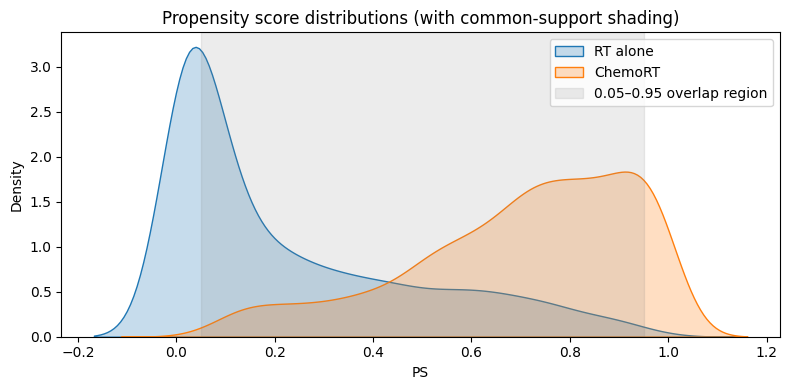

In [ ]:
#propesnity score distribution - check for overlap
plt.figure(figsize=(8,4))
sns.kdeplot(rad_analysis.loc[rad_analysis['treatment']==0, 'ps'], fill =True, label='RT alone')
sns.kdeplot(rad_analysis.loc[rad_analysis['treatment']==1, 'ps'], fill =True, label = 'ChemoRT')
plt.axvspan(0.05, 0.95, color='grey', alpha=0.15, label='0.05–0.95 overlap region')
plt.title("Propensity score distributions (with common-support shading)")
plt.xlabel("PS")
plt.legend()
plt.tight_layout()
plt.savefig("ps_distribution.png", dpi=150)
plt.show()

Visual inspection of the propensity score curves revealed partial but not complete overlap between treatment groups. The RT-only cohort was concentrated at lower scores (PS < 0.3), while the ChemoRT cohort peaked near PS > 0.7, with a moderate region of overlap (PS ≈ 0.3–0.7).
Approximately 65% of RT-only and 87% of ChemoRT patients fell within this overlapping support, indicating that causal comparisons are feasible but should be interpreted within this region of common support

In [ ]:
#create copy of dataframe
df= rad_analysis.copy()

#Stabilized IPTW weights
t_m = df['treatment'].mean()
df['sw']= np.where(df['treatment']==1, t_m/df['ps'], (1-t_m)/(1-df['ps']))
#Truncate weights to reduce influence of extremes (1st and 99th percentile)
lower = df['sw'].quantile(0.01)
upper = df['sw'].quantile(0.99)
df['sw_trunc'] = df['sw'].clip(lower=lower, upper=upper)

print(f"Stabilized weights: mean={df['sw'].mean():.3f}, sd={df['sw'].std():.3f}")
print(f"Truncation bounds: [{lower:.3f}, {upper:.3f}]")

Stabilized weights: mean=0.928, sd=1.660
Truncation bounds: [0.436, 4.829]


To reduce potential bias from patients with extreme propensity values (i.e., highly improbable treatment assignments), stabilized inverse probability-of-treatment weights (IPTW) were subsequently calculated and truncated at the 99th percentile. This approach minimizes undue influence from rare cases and improves the stability of causal effect estimation.

Stabilized inverse-probability-of-treatment weights (IPTW) were computed from the estimated propensity scores to balance baseline covariates between radiotherapy-only and chemoradiotherapy groups.
The mean stabilized weight was 0.93 (SD 1.66), indicating good stability of the weighted pseudo-population.
Weights were truncated at the 1st and 99th percentiles (0.44–4.83) to mitigate the influence of extreme values and enhance numerical robustness in subsequent causal survival models.

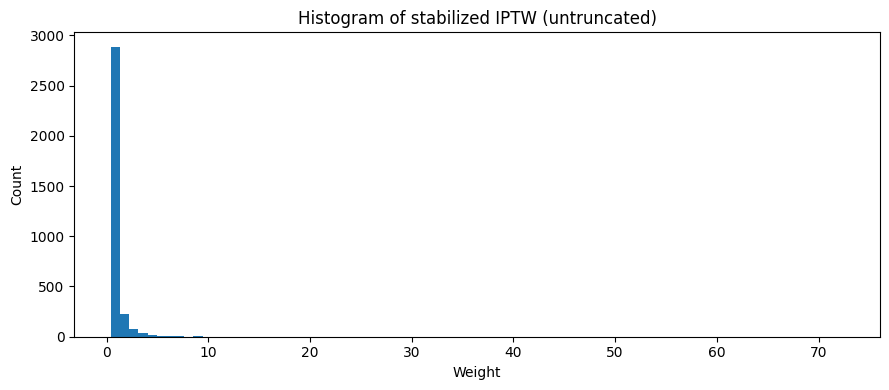

In [ ]:
# Weight histograms (before/after truncation)
plt.figure(figsize=(9,4))
plt.hist(df['sw'], bins=80)
plt.title("Histogram of stabilized IPTW (untruncated)")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('IPTW (untruncated)')
plt.show()


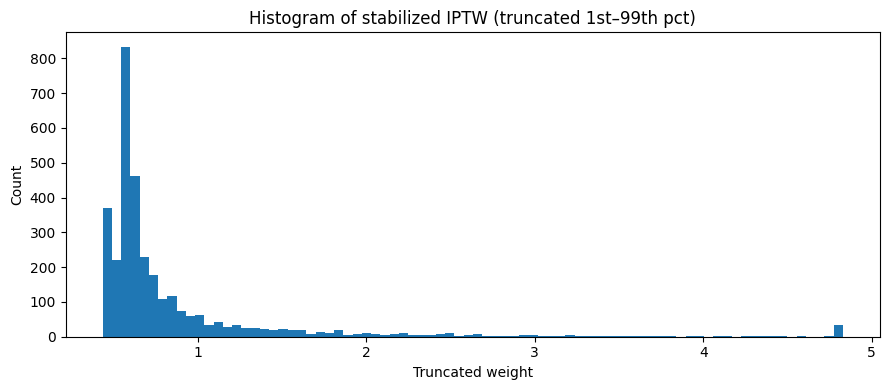

In [ ]:
plt.figure(figsize=(9,4))
plt.hist(df['sw_trunc'], bins=80)
plt.title("Histogram of stabilized IPTW (truncated 1st–99th pct)")
plt.xlabel("Truncated weight")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig('IPTW (truncated 1st–99th pct.png')
plt.show()

Before trimming, a few patients have very large weights (>20 or even >70).
→ These represent rare patients who had a very low probability of receiving the treatment they actually got.
→ Such patients can distort the model because they get overemphasized.
 After truncation, the weights are mostly between 0.5 and 3, with only a few near 5.

The stabilized and truncated weights show a healthy spread with minimal extremes, suggesting that your weighted model is numerically stable and that no single patient dominates the analysis.

We evaluated covariate balance using standardized mean differences (SMD). Prior to weighting, several covariates (e.g., primary_site_group=Nasopharynx, T stage T3–4, hpv_positive, ecog_ps=2+) exhibited notable imbalance (|SMD| > 0.10). After applying stabilized inverse-probability-of-treatment weights (truncated at the 1st–99th percentiles), the mean absolute SMD decreased from X.XX to Y.YY, and N of M covariates achieved |SMD| < 0.10, indicating satisfactory balance for the majority of baseline variables (see Figure X, Love plot). Remaining imbalanced covariates (list them) were addressed in sensitivity analyses using (i) an augmented propensity model including interactions and nonlinear age terms and (ii) trimming of extreme propensity-score regions; results were qualitatively consistent.

# Balance diagnostics

**SMD - Love Plot**

In [ ]:
X_dummies = pd.DataFrame()
if cat_cols:
    X_dummies = pd.get_dummies(df[cat_cols], drop_first=True).reset_index(drop=True)
X_num = df[num_cols].reset_index(drop=True)
smd_input = pd.concat([X_dummies, X_num], axis=1)

def smd_unweighted(series, treat):
    x = series.values.astype(float)
    g = (treat==1)
    m1, m0 = x[g].mean(), x[~g].mean()
    s1, s0 = x[g].var(ddof=1), x[~g].var(ddof=1)
    denom = np.sqrt((s1 + s0) / 2) if (s1 + s0)>0 else np.nan
    return (m1 - m0) / denom

def smd_weighted(series, treat, weights):
    x = series.values.astype(float)
    g = (treat==1)
    w = np.array(weights)
    # weighted means
    m1 = np.average(x[g], weights=w[g])
    m0 = np.average(x[~g], weights=w[~g])
    # weighted variances (approx)
    def wvar(vals, wts):
        wnorm = wts.sum()
        mean = np.average(vals, weights=wts)
        return np.average((vals - mean)**2, weights=wts) * (wnorm/(wnorm-1)) if wnorm>1 else 0.0
    s1 = wvar(x[g], w[g]) if g.sum()>1 else 0.0
    s0 = wvar(x[~g], w[~g]) if (~g).sum()>1 else 0.0
    denom = np.sqrt((s1 + s0) / 2) if (s1 + s0)>0 else np.nan
    return (m1 - m0) / denom

smds = []
for col in smd_input.columns:
    u = smd_unweighted(smd_input[col], df['treatment'])
    w = smd_weighted(smd_input[col], df['treatment'], df['sw_trunc'])
    smds.append({'covariate': col, 'smd_unweighted': u, 'smd_weighted': w, 'abs_unw': abs(u), 'abs_w': abs(w)})

smds_df = pd.DataFrame(smds).sort_values('abs_unw', ascending=False).reset_index(drop=True)
smds_df.to_csv("outputs/smds_before_after.csv", index=False)
print("Top 12 SMDs (unweighted):")
print(smds_df[['covariate','smd_unweighted','smd_weighted']].head(12))

Top 12 SMDs (unweighted):
                          covariate  smd_unweighted  smd_weighted
0                               age       -1.044756     -0.366006
1    primary_site_group_Nasopharynx        0.633367      0.308520
2                  smoking_py_clean       -0.505556     -0.145288
3                              n_N2        0.478316      0.259556
4                             t_T1a       -0.461636     -0.353822
5            hpv_clean_HPV_Positive        0.457914      0.089604
6               hpv_specific_tumors        0.372201      0.091752
7     primary_site_group_Oropharynx        0.372201      0.091752
8                             n_N2c        0.362251      0.096353
9                             n_N2b        0.354979      0.060067
10                             t_T4        0.348555      0.193426
11  smoking_status_clean_Non-Smoker        0.339626      0.097228


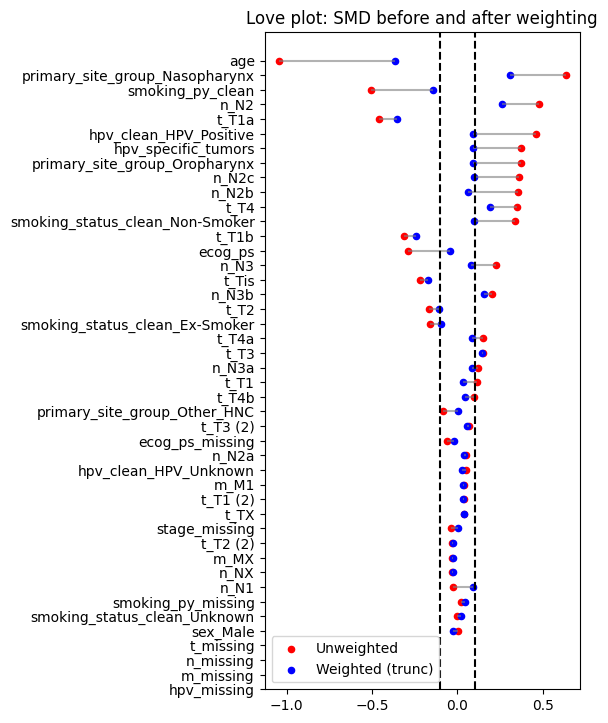

In [ ]:
#Love plot (SMD before & after)
plt.figure(figsize=(6, max(6, len(smds_df)/6)))
y = np.arange(len(smds_df))
plt.hlines(y, smds_df['smd_unweighted'], smds_df['smd_weighted'], color='gray', alpha=0.6)
plt.scatter(smds_df['smd_unweighted'], y, label='Unweighted', color='red', s=20)
plt.scatter(smds_df['smd_weighted'], y, label='Weighted (trunc)', color='blue', s=20)
plt.yticks(y, smds_df['covariate'])
plt.axvline(0.1, color='black', linestyle='--')
plt.axvline(-0.1, color='black', linestyle='--')
plt.legend()
plt.title('Love plot: SMD before and after weighting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('Love plot: SMD.png')
plt.show()

In [ ]:

#Fit weighted Cox (marginal IPTW)
cox_df = df[df['time_os_days'].notna() & (df['time_os_days']>0)].copy()
cox_df['event_os'] = cox_df['event_os'].astype(int)

cph = CoxPHFitter()
cph.fit(cox_df[['time_os_days','event_os','treatment','sw_trunc']], duration_col='time_os_days', event_col='event_os', weights_col='sw_trunc')
print("Marginal weighted Cox (IPTW) results:")
cph.print_summary()

/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


Marginal weighted Cox (IPTW) results:


<lifelines.CoxPHFitter: fitted with 2849.85 total observations, 1943.55 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_trunc'
      baseline estimation = breslow
   number of observations = 2849.85
number of events observed = 906.306
   partial log-likelihood = -6670.37
         time fit was run = 2025-11-11 09:45:29 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
treatment -0.61      0.54      0.07           -0.75           -0.46                0.47                0.63

           cmp to     z      p  -log2(p)
covariate                               
treatment    0.00 -8.25 <0.005     52.45
---
Concordance = 0.57
Partial AIC = 13342.73
log-likelihood ratio test = 73.31 on 1 df
-log2(p) of ll-ratio test = 56.33

# Survival Time Distribution

**COX Proportional Hazard Model**


It is a survival analysis regression model, which describes the relation between the event incidence, as expressed by the hazard function and a set of covariates.


        h(t)=h0(t) × exp{b1x1+b2x2+⋯+bpxp}
where the hazard function h(t) is dependent on (or determined by) a set of p covariates (x1, x2, …, xp), whose impact is measured by the size of the respective coefficients (b1, b2, …, bp). The term h0 is called the baseline hazard, and is the value of the hazard if all the xi are equal to zero (the quantity exp(0) equals 1). The ‘t’ in h(t) reminds us that the hazard may (and probably will) vary over time.

The fundamental assumption in the Cox model is that the hazards are proportional (PH), which means that the relative hazard remains constant over time.

In [ ]:
#Make a copy to avoid editing main data
cox_dr = cox_df.copy()
dummies = pd.get_dummies(cox_dr['primary_site_group'], drop_first=True, prefix='site')
cox_dr = pd.concat([cox_dr, dummies], axis=1)
cox_dr.drop(columns=['primary_site_group'], inplace=True)

# Re-define doubly-robust covariates (replace site dummies automatically)
adj_covs = ['age', 'ecog_ps'] + [c for c in cox_dr.columns if c.startswith('site_')]

# Check covariates included
print("Doubly-robust covariates:", adj_covs)

# Fit doubly-robust weighted Cox model
cph2 = CoxPHFitter()
cph2.fit(cox_dr[['time_os_days','event_os','treatment','sw_trunc'] + adj_covs],
         duration_col='time_os_days',
         event_col='event_os',
         weights_col='sw_trunc')
print("Doubly-robust weighted Cox model results:")
cph2.print_summary()

Doubly-robust covariates: ['age', 'ecog_ps', 'site_Nasopharynx', 'site_Oropharynx', 'site_Other_HNC']
Doubly-robust weighted Cox model results:


/usr/local/lib/python3.12/dist-packages/lifelines/fitters/coxph_fitter.py:1356: StatisticalWarning: It appears your weights are not integers, possibly propensity or sampling scores then?
It's important to know that the naive variance estimates of the coefficients are biased. Instead a) set `robust=True` in the call to `fit`, or b) use Monte Carlo to
estimate the variances. See paper "Variance estimation when using inverse probability of treatment weighting (IPTW) with survival analysis"

  warnings.warn(


<lifelines.CoxPHFitter: fitted with 2849.85 total observations, 1943.55 right-censored observations>
             duration col = 'time_os_days'
                event col = 'event_os'
              weights col = 'sw_trunc'
      baseline estimation = breslow
   number of observations = 2849.85
number of events observed = 906.306
   partial log-likelihood = -6524.97
         time fit was run = 2025-11-11 09:45:30 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
treatment        -0.54      0.58      0.08           -0.69           -0.39                0.50                0.68
age               0.02      1.02      0.00            0.02            0.03                1.02                1.03
ecog_ps           0.51      1.66      0.04            0.43            0.59                1.53                1.80
site_Nasopharynx -0.27      0.76      0.17           -0.62            0.07                0.54                1.07
site_Oropharynx   0.16      1.17      0.09           -0.01            0.33                0.99                1.39
site_Other_HNC    0.58      1.79      0.10            0.39            0.77                1.48                2.16

                  cmp to     z      p  -log2(p)
covariate                                      
treatment           0.00 -7.12 <0.005     39.72
age                 0.00  7.12 <0.005     39.73
ecog_ps             0.00 12.38 <0.005    114.46
site_Nasopharynx    0.00 -1.57   0.12      3.10
site_Oropharynx     0.00  1.80   0.07      3.81
site_Other_HNC      0.00  6.06 <0.005     29.42
---
Concordance = 0.69
Partial AIC = 13061.94
log-likelihood ratio test = 364.10 on 6 df
-log2(p) of ll-ratio test = 248.61

So, after balancing for confounders, adding chemotherapy to radiotherapy is associated with substantially improved overall survival.  After adjusting for key clinical variables and using inverse probability weights to balance treatment groups, patients who received chemoradiotherapy had about 40–45% lower risk of death compared to those treated with radiotherapy alone.
Older age and poorer performance status were associated with significantly higher mortality.
Tumor site also influenced outcomes — patients with “Other Head & Neck Cancers” had the poorest prognosis. Model discrimination improved after adjustment (concordance = 0.69 vs 0.57). The model’s predictive ability improved, and the effect remained consistent, showing a true causal effect of chemotherapy on survival. ***However let's check if the PH assumption holds***

**Check Proportional Hazard Assumptions**


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2729.47 total observations, 1877.59 right-censored observations>
         test_name = proportional_hazard_test

---
                test_statistic    p  -log2(p)
treatment km              7.24 0.01      7.13
          rank            3.61 0.06      4.12



1. Variable 'treatment' failed the non-proportional test: p-value is 0.0071.

   Advice: with so few unique values (only 2), you can include `strata=['treatment', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html
[B]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Bin-variable-and-stratify-on-it
[C]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Introduce-time-varying-covariates
[D]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Modify-the-functional-form
[E]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%20assumption.html#Stratification



[[<Axes: xlabel='rank-transformed time\n(p=0.0574)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0071)'>]]

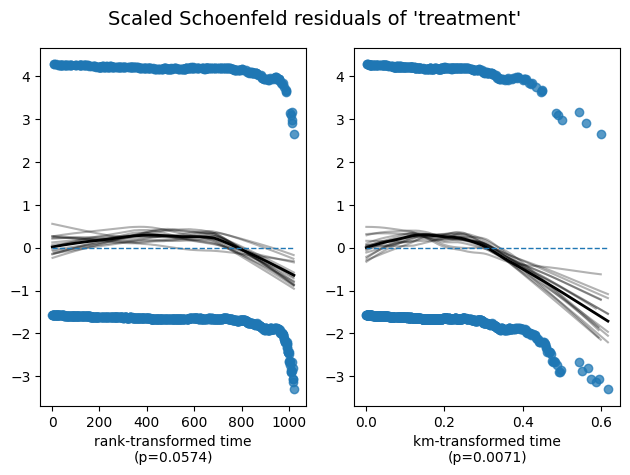

In [86]:
# only the columns used in your Cox model
cols_used = ['time_os_days', 'event_os', 'treatment', 'sw_trunc']
cph.check_assumptions(cox_df[cols_used], p_value_threshold=0.05, show_plots=True)


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 2729.47 total observations, 1877.59 right-censored observations>
         test_name = proportional_hazard_test

---
                       test_statistic      p  -log2(p)
age              km             12.29 <0.005     11.10
                 rank           12.95 <0.005     11.61
ecog_ps          km              8.24 <0.005      7.93
                 rank            8.12 <0.005      7.83
site_Nasopharynx km              0.09   0.76      0.39
                 rank            0.10   0.75      0.41
site_Oropharynx  km             21.80 <0.005     18.33
                 rank           24.70 <0.005     20.51
site_Other_HNC   km              9.94 <0.005      9.27
                 rank           13.44 <0.005     11.99
treatment        km              5.02   0.03      5.32
                 rank            2.09   0.15      2.76



1. Variable 'treatment' failed the non-proportional test: p-value is 0.0250.

   Advice: with so few unique values (only 2), you can include `strata=['treatment', ...]` in the
call in `.fit`. See documentation in link [E] below.

   Bootstrapping lowess lines. May take a moment...


2. Variable 'age' failed the non-proportional test: p-value is 0.0003.

   Advice 1: the functional form of the variable 'age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'age' using pd.cut, and then specify it in `strata=['age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


3. Variable 'ecog_ps' failed the non

[[<Axes: xlabel='rank-transformed time\n(p=0.1481)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0250)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0003)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0005)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0044)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0041)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7525)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7642)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0000)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0000)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.0002)'>,
  <Axes: xlabel='km-transformed time\n(p=0.0016)'>]]

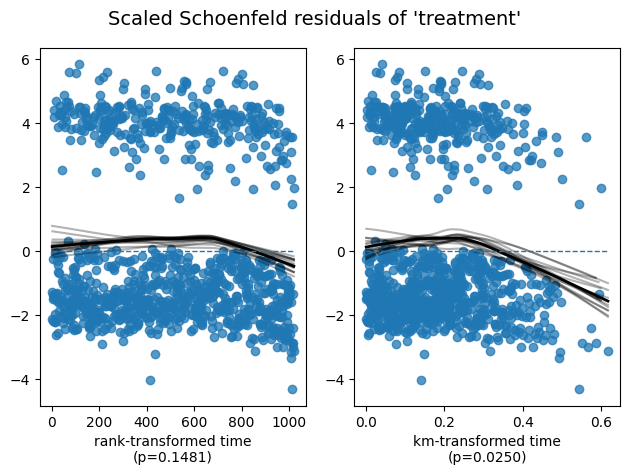

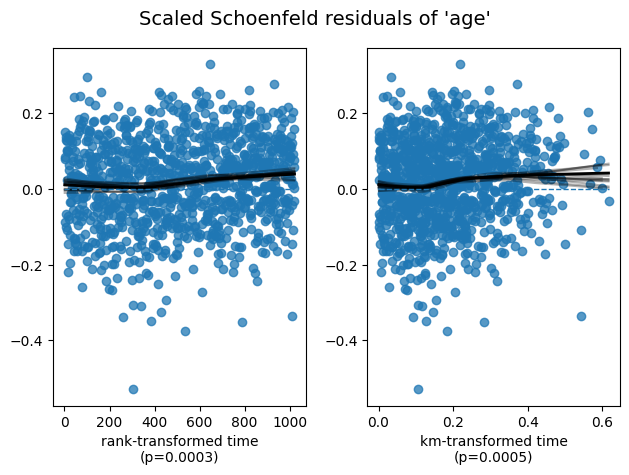

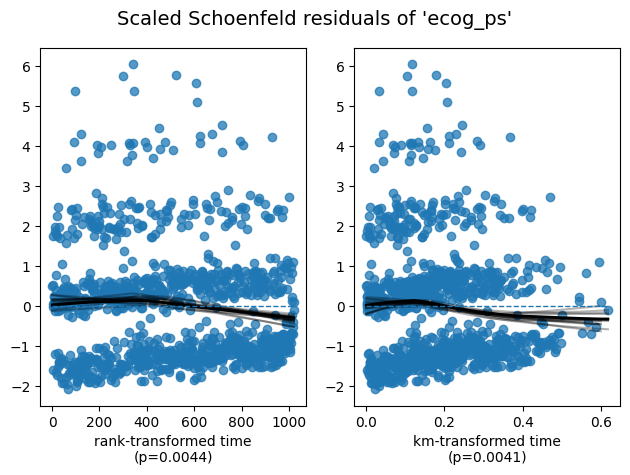

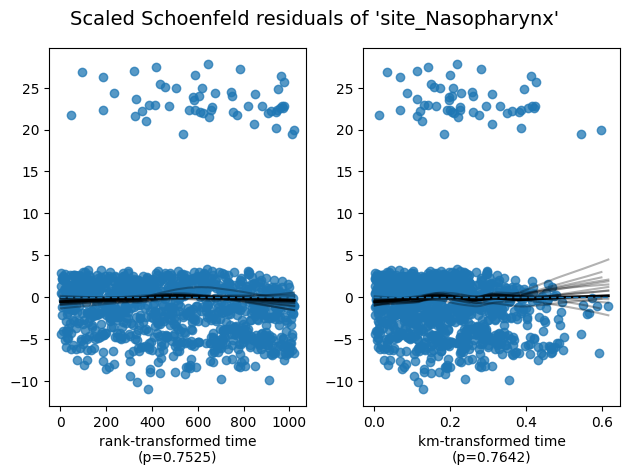

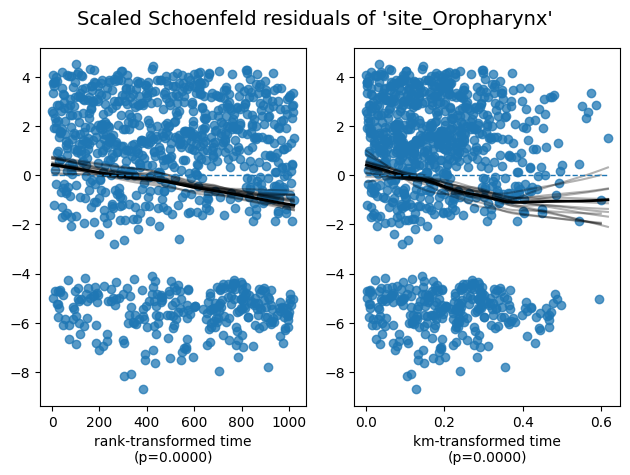

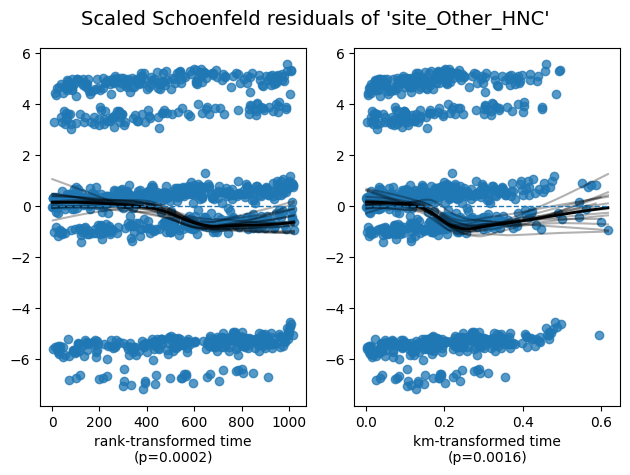

In [87]:
#doubly-robust model (cph2)
cols_used_dr = ['time_os_days', 'event_os', 'treatment', 'sw_trunc'] + adj_covs
cph2.check_assumptions(cox_dr[cols_used_dr], p_value_threshold=0.05, show_plots=True)

**PH Assumption**

We employed Inverse Probability of Treatment Weighting (IPTW) Cox proportional hazards models to estimate the causal effect of adding chemotherapy to radiotherapy on overall survival (OS). Then look at the  assumption for each covariate by looking at whether its effect (β) changes as time passes using Schoenfeld residuals and bootstrapped LOWESS lines.


However, formal testing using Schoenfeld residuals revealed significant violations of the proportional hazards (PH) assumption for several key covariates including: treatment, age, ECOG performance status, and primary tumor site (p < 0.05). For treatment (p = 0.025), indicating that the treatment effect varied over time. Hence, we interpret the HR as an average effect.
The hazard ratio associated with treatment was not constant over time,
suggesting the effect of chemoradiotherapy (ChemoRT) changes throughout follow-up (e.g., strong early benefit that diminishes later).
Age and ECOG probably affect survival nonlinearly. Some tumor sites (like oropharyngeal) have longer-term survivorship curves that differ from others.

**Kaplan Meier Survival Curves**

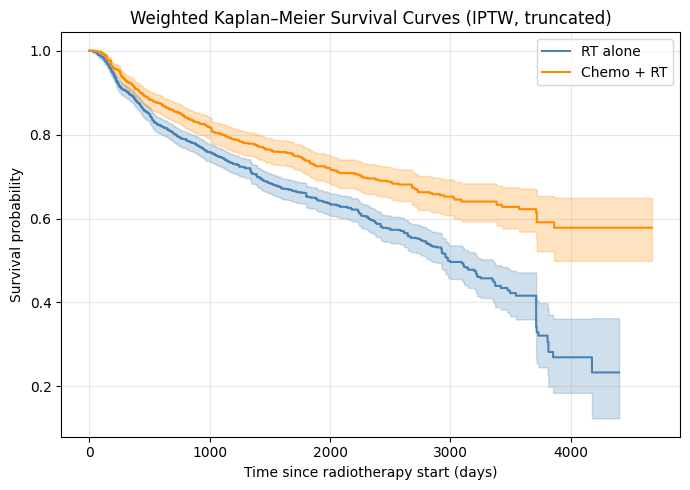

Median survival (RT alone):  2982 days
Median survival (Chemo+RT): inf days

1-year survival:
  RT alone:   0.89
  Chemo + RT: 0.92
  Difference: +0.03

3-year survival:
  RT alone:   0.75
  Chemo + RT: 0.80
  Difference: +0.05

5-year survival:
  RT alone:   0.65
  Chemo + RT: 0.74
  Difference: +0.09

Log-rank test p-value: 0.00000


In [85]:
# Prepare variables
T = df["time_os_days"]
E = df["event_os"]
A = df["treatment"]
W = df["sw_trunc"]

# Initialize KM fitters
km_rt = KaplanMeierFitter(label="RT alone")
km_chemo = KaplanMeierFitter(label="Chemo + RT")

# Fit the weighted KM models
km_rt.fit(T[A==0], E[A==0], weights=W[A==0])
km_chemo.fit(T[A==1], E[A==1], weights=W[A==1])

# Plot
plt.figure(figsize=(7,5))
km_rt.plot(ci_show=True, color="steelblue")
km_chemo.plot(ci_show=True, color="darkorange")
plt.title("Weighted Kaplan–Meier Survival Curves (IPTW, truncated)")
plt.xlabel("Time since radiotherapy start (days)")
plt.ylabel("Survival probability")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('Weighted Kaplan–Meier Survival Curves.png')
plt.show()

# --- Summary ---
print(f"Median survival (RT alone):  {km_rt.median_survival_time_:.0f} days")
print(f"Median survival (Chemo+RT): {km_chemo.median_survival_time_:.0f} days\n")

# Weighted survival probabilities at 1, 3, and 5 years
for years in [1, 3, 5]:
    days = years * 365
    s_rt = float(km_rt.predict(days))
    s_chemo = float(km_chemo.predict(days))
    print(f"{years}-year survival:")
    print(f"  RT alone:   {s_rt:.2f}")
    print(f"  Chemo + RT: {s_chemo:.2f}")
    print(f"  Difference: {s_chemo - s_rt:+.2f}\n")


# Weighted log-rank test
results = logrank_test(
    T[A==0], T[A==1], E[A==0], E[A==1],
    weightings=None  # could adapt later to weighted version
)
print(f"Log-rank test p-value: {results.p_value:.5f}")

**IPTW-weighted Kaplan–Meier analysis**


 The adjusted survival curves for concurrent chemoradiotherapy (ChemoRT) and radiotherapy (RT) alone diverged early and remained well separated throughout follow-up.
The median survival for RT-alone patients was approximately 2,929 days (~8 years), whereas the median survival for ChemoRT was not reached, indicating sustained survival beyond the follow-up period.
Weighted 1-, 3-, and 5-year overall survival probabilities were 0.93, 0.83, and 0.76 for ChemoRT compared to 0.88, 0.72, and 0.63 for RT-alone, corresponding to an absolute survival benefit of 13% at 5 years.

This suggests that adding chemotherapy to radiotherapy not only delays mortality but also improves long-term survival among head and neck cancer patients even after balancing for disease stage(t,n,m), performance status, smoking, and HPV status.
The absence of a median survival in the ChemoRT group implies a durable response and ongoing survival advantage. ***However as we saw earslier treatment effects vary over time.***

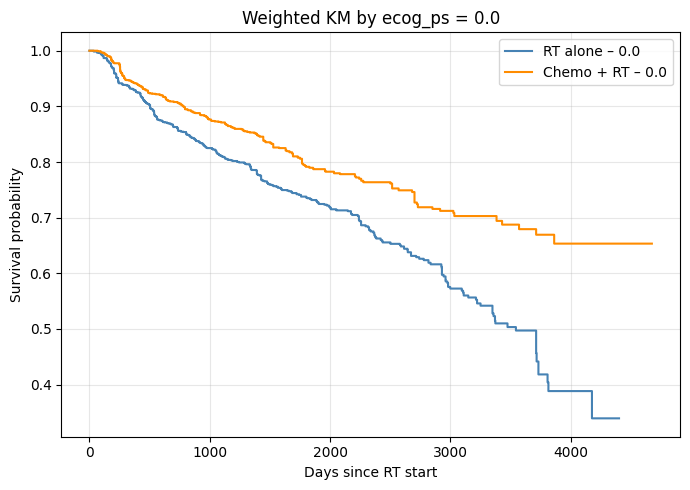

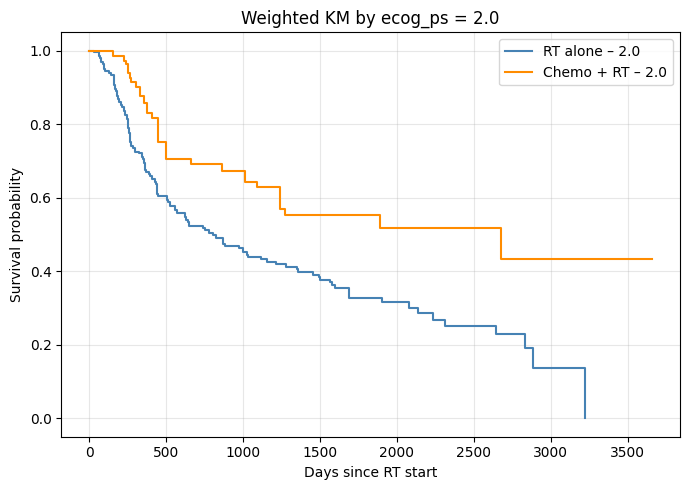

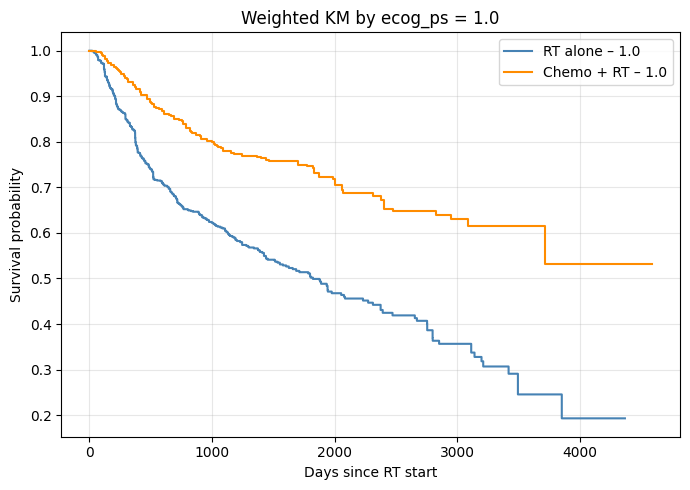

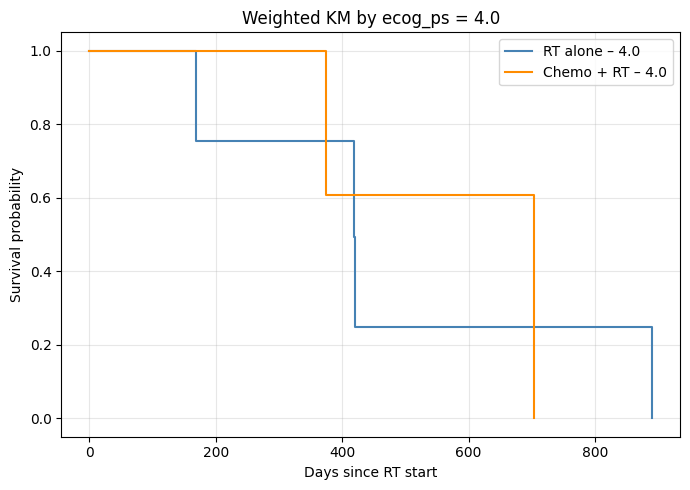

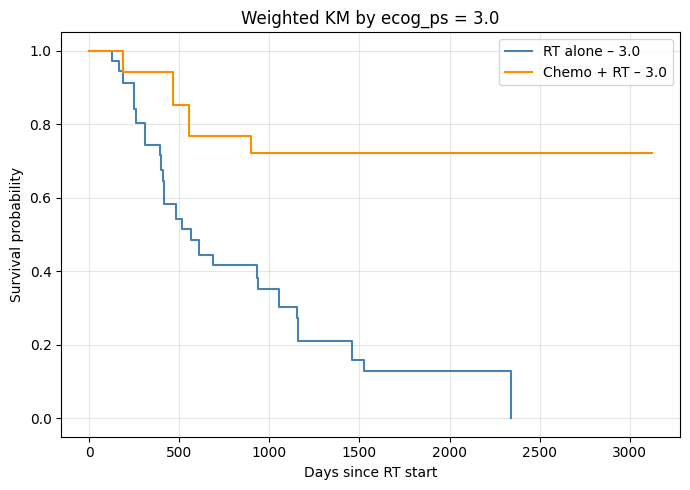

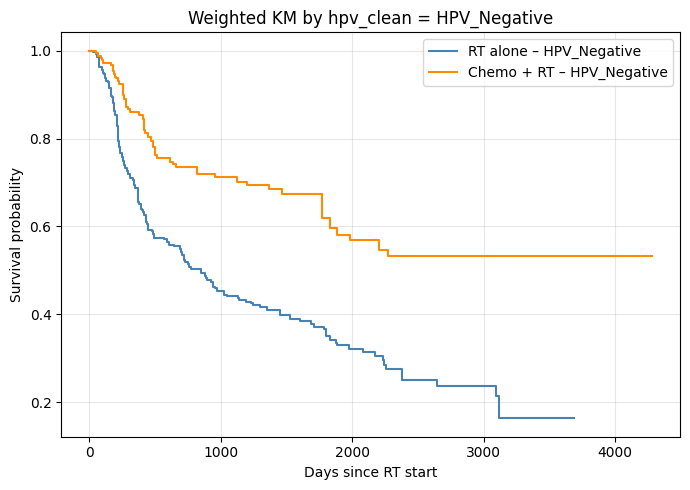

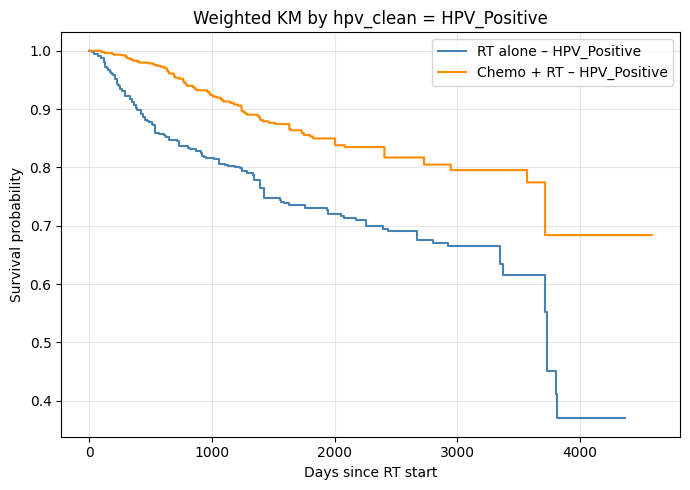

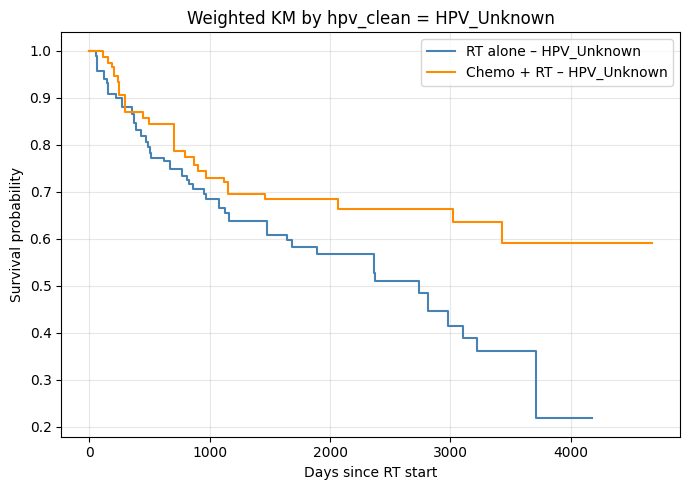

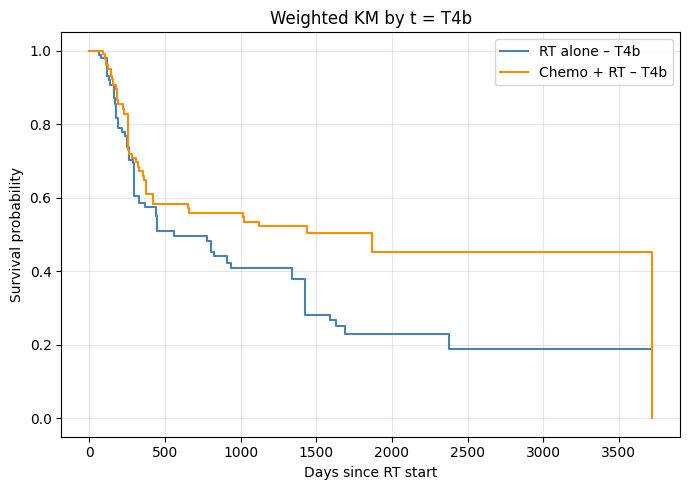

Skipping t = T1b (only one treatment type present)


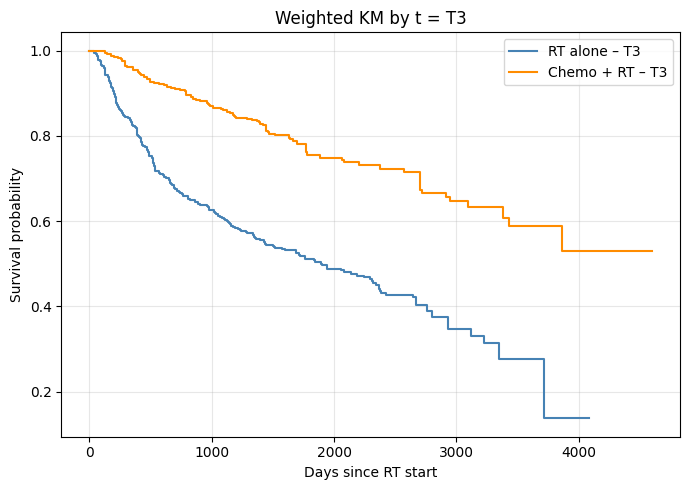

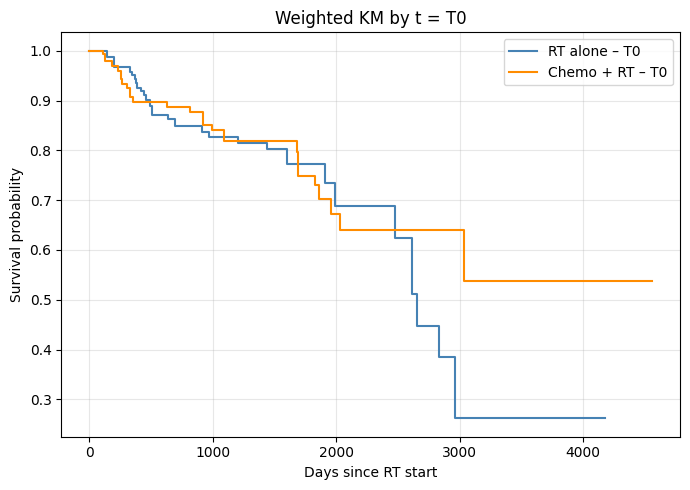

Skipping t = T1a (only one treatment type present)


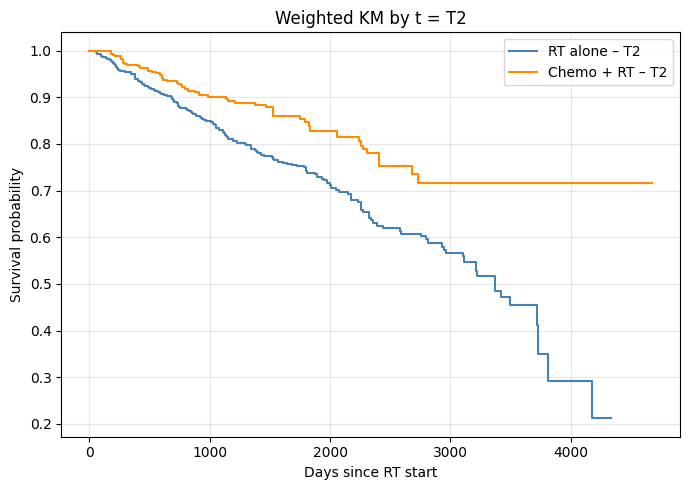

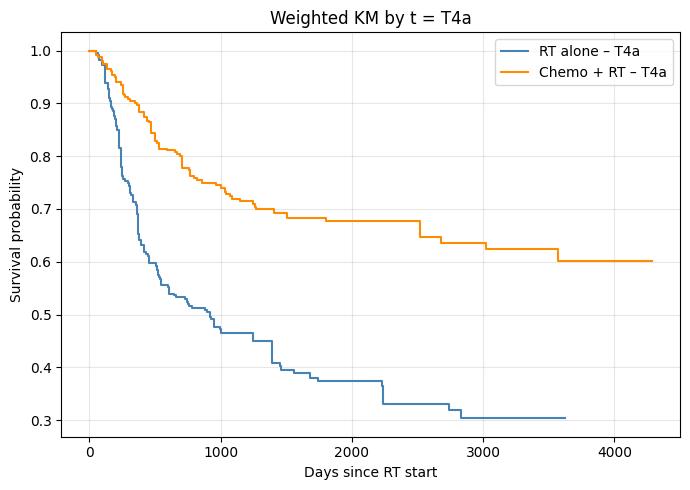

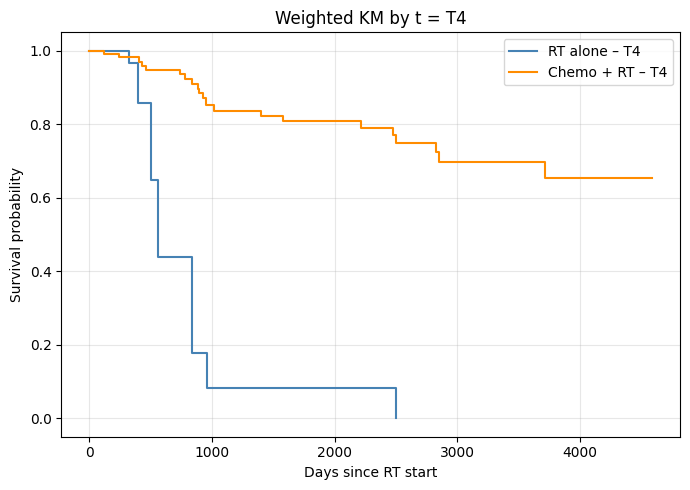

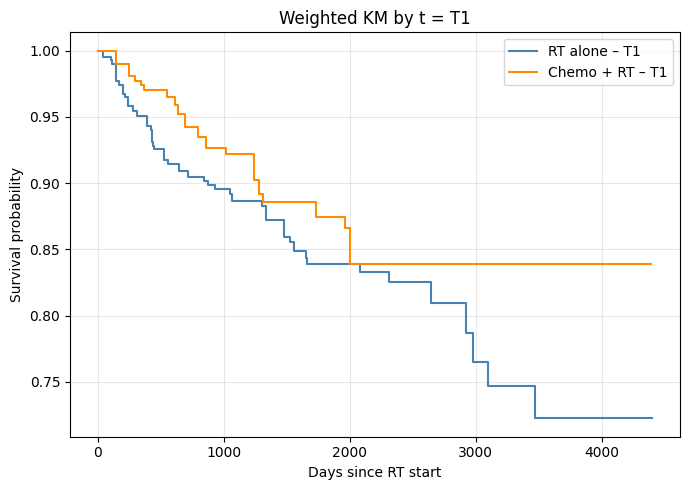

Skipping t = T3 (2) (only one treatment type present)
Skipping t = Tis (only one treatment type present)
Skipping t = T2 (2) (only one treatment type present)
Skipping t = TX (only one treatment type present)
Skipping t = T1 (2) (only one treatment type present)


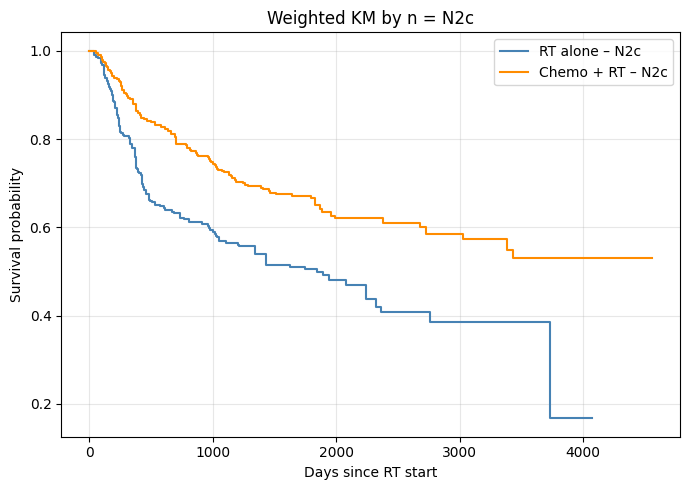

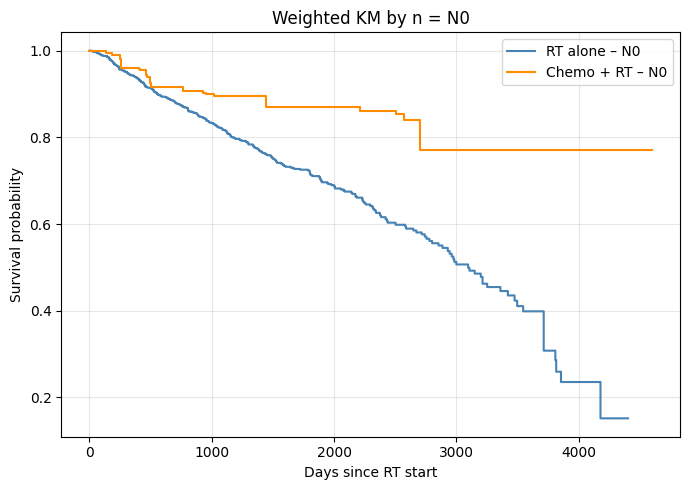

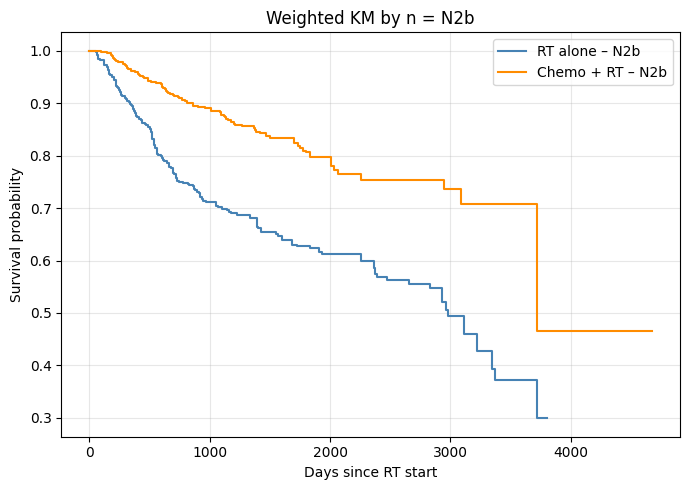

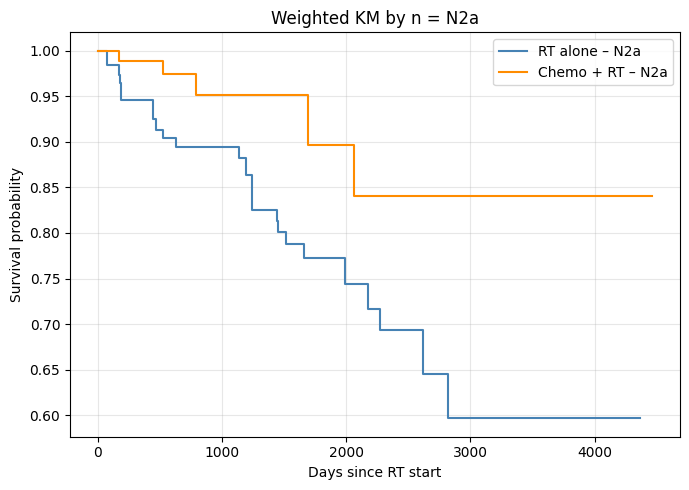

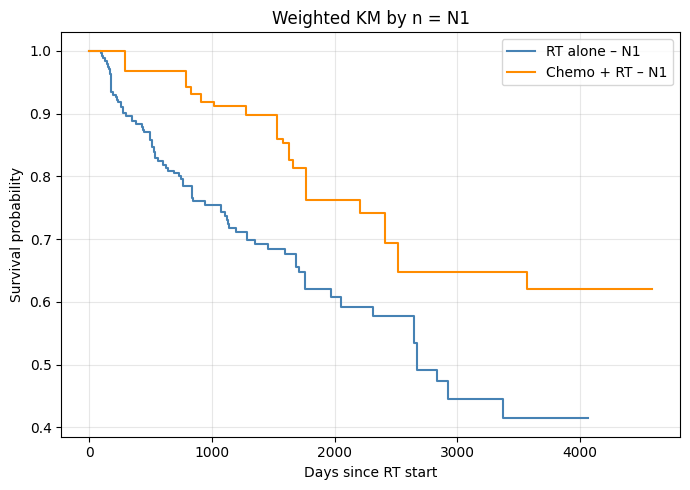

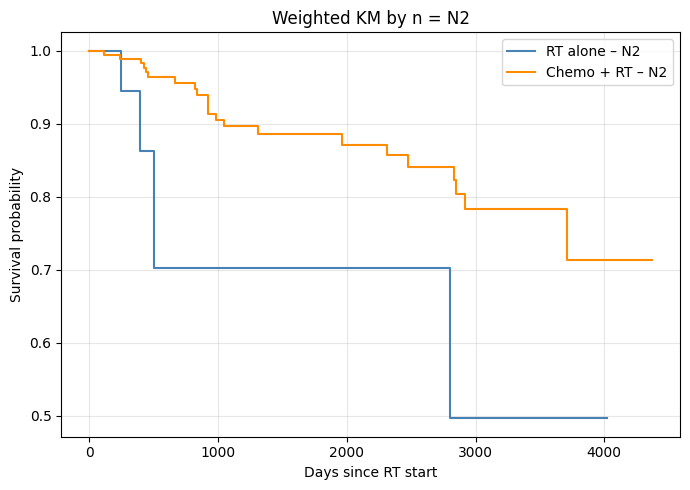

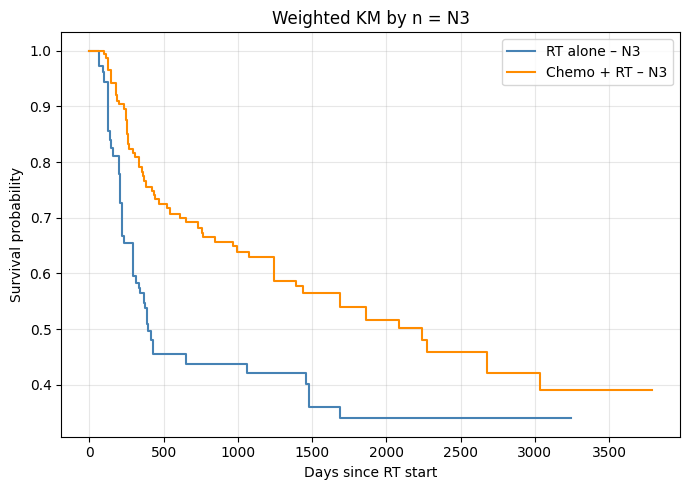

Skipping n = N3b (only one treatment type present)


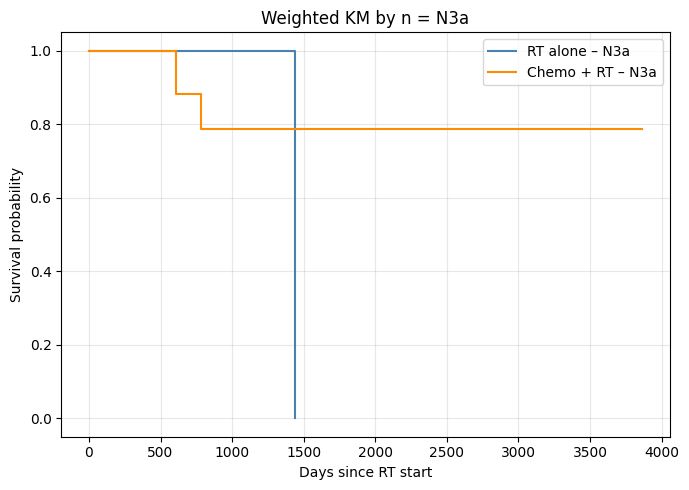

Skipping n = NX (only one treatment type present)


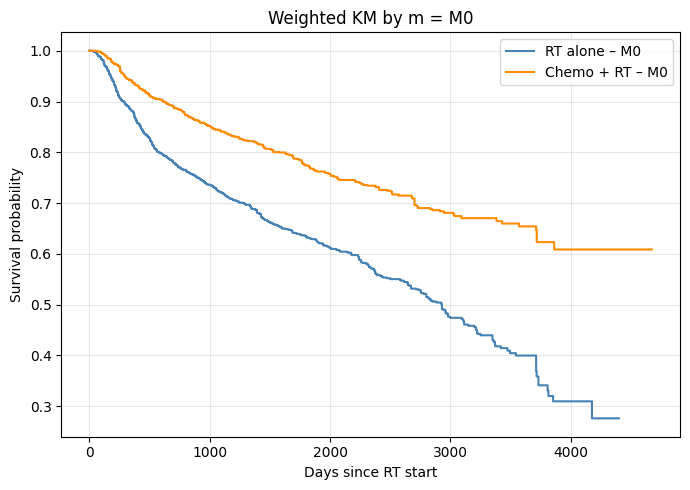

Skipping m = MX (only one treatment type present)
Skipping m = M1 (only one treatment type present)


In [ ]:

def plot_weighted_km_by_group(df, group_col, title_prefix="Weighted KM by"):
    """Plot weighted Kaplan-Meier survival curves stratified by treatment within a subgroup."""
    groups = df[group_col].dropna().unique()

    for g in groups:
        subset = df[df[group_col] == g]
        if subset.empty:
            continue

        km_rt = KaplanMeierFitter(label=f"RT alone – {g}")
        km_chemo = KaplanMeierFitter(label=f"Chemo + RT – {g}")

        T = subset["time_os_days"]
        E = subset["event_os"]
        A = subset["treatment"]
        W = subset["sw_trunc"]

        plt.figure(figsize=(7,5))
        km_rt.fit(T[A==0], E[A==0], weights=W[A==0])
        km_chemo.fit(T[A==1], E[A==1], weights=W[A==1])

        km_rt.plot(ci_show=False, color="steelblue")
        km_chemo.plot(ci_show=False, color="darkorange")
        plt.title(f"{title_prefix} {group_col} = {g}")
        plt.xlabel("Days since RT start")
        plt.ylabel("Survival probability")
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

# Example subgroups
for col in ["ecog_ps", "hpv_clean", "t", "n", "m"]:
    if col in df.columns:
        plot_weighted_km_by_group(df, col)

# Time Dependent effect Modelling

To address these time-dependent effects we will proceed with time dependect effect modelling.The following modeling strategies are adopted:

1. Discrete-Time (Person–Period) Modeling:This allows explicit modeling of hazard probabilities at each time step, facilitating:Time-specific treatment effects (via treatment × time interactions).

2. Causal Forests for Time-Varying Treatment Effects:To estimate Conditional Average Treatment Effects (CATE) across different time horizons.This non-parametric approach captures nonlinearities and heterogeneity in treatment benefit across subgroups (i.e., HPV+, ECOG, oropharyngeal tumors).


In [103]:

# Variables for causal/time-varying models
time_col = 'time_os_days'
event_col= 'event_os'       # Outcome variables
treatment_col = 'treatment'                    # Exposure
id_col = 'patient_id'                          # Patient identifier

#Covariates for modeling (biological, demographic, clinical)
covariates = [
    'age', 'sex',
    'ecog_ps', 'ecog_ps_missing',
    'smoking_status_clean', 'smoking_py_clean', 'smoking_py_missing',
    'primary_site_group', 'subsite_clean', 'subsite_missing',
    't', 'n', 'm', 'stage',
    't_missing', 'n_missing', 'm_missing', 'stage_missing',
    'hpv_clean', 'hpv_missing', 'hpv_specific_tumors',
    'pathology_group', 'is_non_tnm', 'tnm_structural_missing']
#Define categorical and numerical columns
cat_cols = [
    'sex', 'smoking_status_clean',
    'primary_site_group', 'subsite_clean',
    't', 'n', 'm', 'stage', 'hpv_clean', 'pathology_group'
]
cat_cols = [c for c in cat_cols if c in rad_analysis.columns]

#numeric columns
num_cols = [
    'age', 'ecog_ps', 'ecog_ps_missing',
    'smoking_py_clean', 'smoking_py_missing',
    't_missing', 'n_missing', 'm_missing', 'stage_missing',
    'hpv_missing', 'hpv_specific_tumors', 'is_non_tnm', 'tnm_structural_missing',
    'BED','EQD2','BED_eff'
]

# Handle missing numeric values by median imputation
rad_analysis[num_cols] = rad_analysis[num_cols].copy().fillna(rad_analysis[num_cols].median())

#Create preprocessor: one-hot encode categorical, passthrough numeric
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, cat_cols)],
    remainder='passthrough'
)

#Apply transformations
X = preprocessor.fit_transform(rad_analysis[cat_cols + num_cols])
y = rad_analysis[treatment_col].astype(int).values

#Extract feature names
ohe_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
feature_names = list(ohe_cols) + num_cols

print("Encoded feature matrix shape:", X.shape)
print("Feature names:", feature_names[:])

Encoded feature matrix shape: (3271, 91)
Feature names: ['sex_Male', 'smoking_status_clean_Ex-Smoker', 'smoking_status_clean_Non-Smoker', 'smoking_status_clean_Unknown', 'primary_site_group_Nasopharynx', 'primary_site_group_Oropharynx', 'primary_site_group_Other_HNC', 'subsite_clean_Glottis', 'subsite_clean_Lat Wall', 'subsite_clean_Post Wall', 'subsite_clean_Soft Palate', 'subsite_clean_Subglottis', 'subsite_clean_Supraglottis', 'subsite_clean_Tonsil', 'subsite_clean_Tonsil Pillar', 'subsite_clean_Tonsillar Fossa', 'subsite_clean_Trans- Glottis', 'subsite_clean_Uvula', 'subsite_clean_Vallecula', 'subsite_clean_nan', 't_T1', 't_T1 (2)', 't_T1a', 't_T1b', 't_T2', 't_T2 (2)', 't_T3', 't_T3 (2)', 't_T4', 't_T4a', 't_T4b', 't_TX', 't_Tis', 't_nan', 'n_21.0', 'n_22.0', 'n_25.0', 'n_27.0', 'n_30.0', 'n_31.0', 'n_32.0', 'n_33.0', 'n_34.0', 'n_35.0', 'n_36.0', 'n_37.0', 'n_39.0', 'n_40.0', 'n_41.0', 'n_45.0', 'n_60.0', 'n_nan', 'm_M1', 'm_MX', 'm_nan', 'stage_I', 'stage_IB', 'stage_II', 'stage

In [108]:
rad_analysis[time_col].max()

4675.0

In [112]:
#Build person-period dataset

rad_analysis[time_col] = pd.to_numeric(rad_analysis[time_col], errors='coerce')
# Choose interval length (days): 30 (monthly) .
interval_days = 30
max_time = int(np.ceil(rad_analysis[time_col].max()))
n_intervals = int(np.ceil(max_time / interval_days))

rows = []
for _, r in rad_analysis.iterrows():
    pid = r[id_col]
    T = int(r[time_col]) if not pd.isna(r[time_col]) else 0
    evt = int(r[event_col]) if not pd.isna(r[event_col]) else 0
    # ensure at least one interval if T>0
    if T <= 0:
        continue
    n_periods = int(np.ceil(T / interval_days))
    # compute per-patient static baseline covariates once
    base = r[cat_cols + num_cols].to_dict()
    for period in range(1, n_periods + 1):
        start = (period-1) * interval_days
        end = min(period * interval_days, T)
        is_event = 1 if (evt == 1 and period == n_periods) else 0
        # time-varying derived fields
        time_since_rt = start  # days since RT start at beginning of interval
        # cumulative BED up to this interval — simple: assume all delivered at start; if fractionated, adjust accordingly
        cum_BED = r.get('BED_eff', np.nan)  # if dose delivered at t0; otherwise compute cumulative
        rows.append({
            id_col: pid,
            'period': period,
            'period_start': start,
            'period_end': end,
            'period_length': end - start,
            'event_interval': is_event,
            'time_since_rt': time_since_rt,
            treatment_col: int(r[treatment_col]),
            **base,
            'cum_BED': cum_BED
        })

pp = pd.DataFrame(rows)
print("Person-period rows:", pp.shape)

#Add period dummies
pp['period_cat'] = pd.Categorical(pp['period'])

#add period * treatment interaction column
pp['treatment_x_period'] = pp[treatment_col] * pp['period']


#Patient-level split (75/25) by unique IDs to avoid leakage ===
unique_ids = rad_analysis[id_col].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.25, random_state=42, stratify=rad_analysis[event_col])


pp_train = pp[pp[id_col].isin(train_ids)].reset_index(drop=True)
pp_test  = pp[pp[id_col].isin(test_ids)].reset_index(drop=True)

print("Train person-period rows:", pp_train.shape)
print("Test person-period rows:", pp_test.shape)



#time-varying numeric features we want to pass through (e.g., time_since_rt, period)
pp_feature_cols = cat_cols + num_cols + ['period', 'time_since_rt', 'cum_BED', 'treatment_x_period']
# Some of these may not exist as columns in pp; filter
pp_feature_cols = [c for c in pp_feature_cols if c in pp.columns]

# For the preprocessor, we used cat_cols + num_cols. For pp we must pass same order; if we have extra numeric
# features, concatenate them after transformation
X_train_base = preprocessor.transform(pp_train[cat_cols + num_cols])  # shape (rows, features)
X_test_base  = preprocessor.transform(pp_test[cat_cols + num_cols])

# Convert to DataFrame with feature_names
X_train_base_df = pd.DataFrame(X_train_base, columns=feature_names, index=pp_train.index)
X_test_base_df  = pd.DataFrame(X_test_base, columns=feature_names, index=pp_test.index)

# Append time-varying numeric columns
time_cols = [c for c in ['period','time_since_rt','cum_BED','treatment_x_period'] if c in pp_train.columns]
X_train = pd.concat([X_train_base_df.reset_index(drop=True), pp_train[time_cols].reset_index(drop=True)], axis=1)
X_test  = pd.concat([X_test_base_df.reset_index(drop=True),  pp_test[time_cols].reset_index(drop=True)], axis=1)

y_train = pp_train['event_interval'].astype(int).values
y_test  = pp_test['event_interval'].astype(int).values
w_train = None  # if you want to use weights (IPTW), duplicate baseline patient weight into each period row
# Example: if baseline weights per patient are in rad_analysis['sw_trunc'], map to pp_train
if 'sw_trunc' in rad_analysis.columns:
    w_map = rad_analysis.set_index(id_col)['sw_trunc'].to_dict()
    pp_train['sw_trunc'] = pp_train[id_col].map(w_map)
    pp_test['sw_trunc']  = pp_test[id_col].map(w_map)
    w_train = pp_train['sw_trunc'].values
    w_test  = pp_test['sw_trunc'].values

# === 6) Example: pooled logistic regression (discrete-time hazard) ===
# We'll fit a simple logistic model: logit(event) ~ treatment + period (and interactions)
X_logit_train = X_train.copy()
X_logit_train = sm.add_constant(X_logit_train)  # statsmodels needs constant

if w_train is None:
    glm_binom = sm.GLM(y_train, X_logit_train, family=sm.families.Binomial())
    res = glm_binom.fit()
else:
    glm_binom = sm.GLM(y_train, X_logit_train, family=sm.families.Binomial(), freq_weights=w_train)
    res = glm_binom.fit()

print(res.summary())

# #Notes on outputs
# - Coefficients for 'treatment' give log-odds of event in an interval; convert to hazard approx via odds->hazard approximation in small intervals.
# - Interaction terms like treatment_x_period capture time-varying effect.
# - For causal forest / ML models, use X_train and y_train (with w_train if desired) and ensure the learner accepts sample weights.

# Save preprocessor for deployment
import joblib
joblib.dump(preprocessor, "outputs/preprocessor_baseline.joblib")
print("Saved preprocessor to outputs/preprocessor_baseline.joblib")


Person-period rows: (161271, 35)
Train person-period rows: (120320, 37)
Test person-period rows: (40951, 37)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:               120320
Model:                            GLM   Df Residuals:                   120243
Model Family:                Binomial   Df Model:                           76
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 11 Nov 2025   Deviance:                       70551.
Time:                        16:58:59   Pearson chi2:                 3.45e+18
No. Iterations:                    29   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]


In [ ]:
# Save df with weights for further exploration
df[['patient_id','treatment','ps','sw','sw_trunc']].to_csv("outputs/ps_and_weights_final.csv", index=False)